In [1]:
## Loading functions
import os
os.chdir("/data/biocomp/bahin/qPCR/qPCRquantification/")
import HiFit_pd
from HiFit_pd import *

In [ ]:
import importlib
importlib.reload(HiFit_pd)

In [198]:
cycles_col = ["F" + str(i) for i in range(40)]

In [3]:
## Derivative functions
import numpy as np

def derivative(fx):
    df = [0] + [fx[i]-fx[i-1] for i in range(1, len(fx))]
    return df

def second_derivative(fx):
    df = [0] + [fx[i]-fx[i-1] for i in range(1, len(fx))]
    ddf = [0, 0] + [df[i]-df[i-1] for i in range(2, len(df))]
    return ddf

def max_second_derivative(fx):
    return np.argmax(second_derivative(fx))

def min_second_derivative(fx):
    return np.argmin(second_derivative(fx))

def null_second_derivative(fx):
    return int(np.median((max_second_derivative(fx),min_second_derivative(fx))))

In [262]:
## Creating a DataFrame of the last fluo values as it is on the chip 2.0
# Getting only the sample, the assay and the fluo value
dataset = data_all[["Sample", "Assay", "F39"]]
# Pivoting the data so that it's a 96*96 matrix
df = dataset.pivot(index="Assay", columns="Sample", values="F39")

# Creating the physical order assay and sample lists
assay_IDs = [x for x in range(1, 49)] + [y for x in range(48, 91, 6) for y in range(x+6, x, -1)]
sample_IDs = [None] * 96
sample_IDs[::2] = [y for x in range(43, 0, -6) for y in range(x, x+6)]
sample_IDs[1::2] = [x for x in range(49, 97)]

# Reordering the matrix
reordered_data = df[sample_IDs].reindex(assay_IDs)
display(reordered_data.tail(6))

# Melting the DataFrame (first creating an explicite column with the assay for the melt)
reordered_data_melt = reordered_data.copy()
reordered_data_melt["Assay"] = reordered_data_melt.index
reordered_data_melt = pd.melt(reordered_data_melt, id_vars="Assay", value_vars=reordered_data.columns, value_name="f39")
#display(df.tail())

Sample        43        49        44        50        45        51        46  \
Assay                                                                          
96      0.765505  0.752268  0.750461  0.756888  0.780393  0.752145  0.345700   
95      0.755396  0.728061  0.735778  0.744947  0.755590  0.742256  0.334896   
94      0.735400  0.712777  0.717766  0.727636  0.753529  0.731940  0.329930   
93      0.714861  0.682577  0.695428  0.703209  0.724370  0.701464  0.319641   
92      0.667462  0.638164  0.650096  0.666244  0.681465  0.658617  0.302726   
91      0.565086  0.553361  0.563129  0.580261  0.593516  0.589395  0.262122   

Sample        52        47        53  ...        2         92        3   \
Assay                                 ...                                 
96      0.746482  0.785592  0.737580  ...  0.800974  0.827743  0.759112   
95      0.732408  0.760100  0.719846  ...  0.823275  0.851203  0.775240   
94      0.721813  0.763424  0.712245  ...  0.807571  0.831884  0.750755   
93      0.700536  0.733609  0.691112  ...  0.815703  0.841677  0.759392   
92      0.654823  0.689453  0.666067  ...  0.772438  0.796499  0.768394   
91      0.567213  0.603931  0.599649  ...  0.660502  0.693617  0.644470   

Sample        93        4         94        5         95        6         96  
Assay                                                                         
96      0.800916  0.719345  0.756591  0.659760  0.727018  0.617773  0.298831  
95      0.818355  0.724920  0.768098  0.647189  0.713235  0.474496  0.300995  
94      0.798050  0.707531  0.742121  0.624969  0.692790  0.602594  0.295475  
93      0.810978  0.717234  0.748764  0.637114  0.695477  0.599853  0.299385  
92      0.771691  0.687075  0.717330  0.609343  0.665684  0.589125  0.290160  
91      0.674968  0.594488  0.637574  0.576225  0.602107  0.233132  0.259363  

[6 rows x 96 columns]

In [263]:
## Creating a DataFrame of the sum of the F39 value of the neighbors for each well 2.0
from scipy import ndimage

# Transforming the DataFrame to a numpy array (to convolve)
f39 = reordered_data.values
#np.random.shuffle(f39.flat)  # Shuffling the data to produce the random plot

# Making the convolution
k = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
f39_convolved = ndimage.convolve(f39, k)

# Transforming the convolved numpy array to a melted DataFrame
f39_convolved = pd.DataFrame(f39_convolved, index=reordered_data.index, columns=reordered_data.columns)
f39_convolved["Assay"] = f39_convolved.index # Creating a column to explicitely specify the assay (necessary to melt)
#display(f39_convolved.tail())
f39_convolved_melt = pd.melt(f39_convolved, id_vars="Assay", value_vars=list(f39_convolved.columns)[0:-1], value_name="f39_neighbor_sum")
display(f39_convolved_melt.tail())

Assay Sample  f39_neighbor_sum
9211     95     96          3.184471
9212     94     96          3.173179
9213     93     96          3.262227
9214     92     96          2.829767
9215     91     96          2.413799

Assay Sample       f39  f39_neighbor_sum  Sigmoid_curve
0      1     43  0.905684          7.662053           True
1      2     43  1.029036          8.060074           True
2      3     43  1.063955          8.643461           True
3      4     43  1.095952          8.860493           True
4      5     43  1.098977          8.995093           True

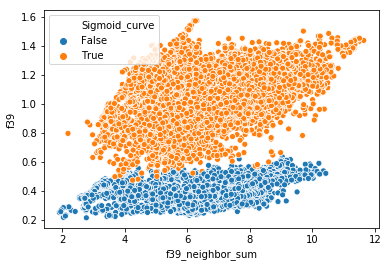

In [264]:
## Plotting the f39 value against the sum of the neighbor f39
# Merging the 2 DataFrame
df = reordered_data_melt.merge(f39_convolved_melt, on=["Assay", "Sample"])
df = df.merge(data_all[["Assay", "Sample", "Sigmoid_curve"]], on=["Assay", "Sample"])
display(df.head())

ax = sns.scatterplot(x="f39_neighbor_sum", y="f39", hue="Sigmoid_curve", data=df)
#sns.jointplot("f39", "f39_neighbor_sum", data=df, kind="hex")

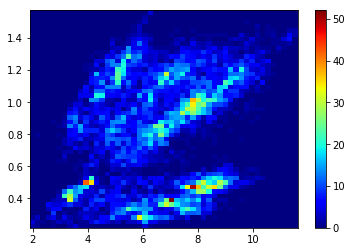

In [267]:
plt.hist2d(df.f39_neighbor_sum, df.f39, (50, 50), cmap=plt.cm.jet)
plt.colorbar()

In [11]:
## Visualizing one curve and its characteristics 2.0
import seaborn as sns
import numpy as np
%matplotlib inline

# Setting the well
sample = "55"
assay = "38"
wellID = "S" + sample + "-A" + assay

# Building the DataFrame of observed fluo
fluo_dataset = fluo.loc[fluo.WellID == wellID]
fluo_dataset.loc[:, "Type"] = "Observed"

# Building the derivative curve
fluo_d = fluo_dataset.copy()
fluo_d.loc[:, "Fluo_value"] = derivative(list(fluo_dataset.Fluo_value))
fluo_d.loc[:, "Type"] = "First_derivative"
#display(fluo_sd)

# Building the second derivative curve
fluo_sd = fluo_dataset.copy()
fluo_sd.loc[:, "Fluo_value"] = second_derivative(list(fluo_dataset.Fluo_value))
fluo_sd.loc[:, "Type"] = "Second_derivative"
#display(fluo_sd)

# Merging the 2 DataFrames
df = pd.concat([fluo_dataset, fluo_d, fluo_sd], sort=False, ignore_index=True)
#df = pd.concat([fluo_dataset, fluo_sd], sort=False, ignore_index=True)
#display(df)

# Plotting the fluo curve
sns.set()
plt.figure(figsize=(10, 10))
sns.lineplot(x="Cycle", y="Fluo_value", hue="Type", data=df)
plt.axvline(x=np.argmin(list(df.loc[df.Type == "First_derivative", "Fluo_value"])), color="yellow")
plt.axvline(x=np.argmin(list(df.loc[df.Type == "Second_derivative", "Fluo_value"])), color="red")
plt.axvline(x=np.argmin(area_under_chord_pd(fluo_dataset["Fluo_value"])[0]), color="green")
#plt.axhline(y=0.3, color="brown", label="Max second derivative")

NameError: name 'fluo' is not defined

In [17]:
s = pd.Series([0.3, 1.2, 0.02, 1.35])
#print(logistic4parameters(np.array(range(40)), 0.3, 1.2, 0.02, 1.35))
print(logistic4parameters(np.array(range(40)), *s))

df = pd.DataFrame(np.array([["S01", 0.3, 1.2, 0.02, 1.35], ["S02", 0.4, 1.0, 0.001, 1.2]]), columns=["WellID", "P_a", "P_b", "P_c", "P_d"])
display(df)

s2 = df.loc[df.WellID == "S01"][["P_a", "P_b", "P_c", "P_d"]].astype(float).T.squeeze()
print(logistic4parameters(np.array(range(40)), *s2))

[0.32       0.32679162 0.33579573 0.34766078 0.36317118 0.38323627
 0.40884567 0.44097436 0.48042395 0.52760262 0.58227847 0.64338127
 0.70895413 0.77633315 0.84254782 0.90482668 0.96103397 1.00990219
 1.05102905 1.08470337 1.11166109 1.13285511 1.14928205 1.16187412
 1.171445   1.17867271 1.18410435 1.18817128 1.19120803 1.19347089
 1.19515451 1.19640573 1.19733482 1.19802428 1.19853567 1.19891485
 1.19919593 1.19940426 1.19955863 1.19967302]


WellID  P_a  P_b    P_c   P_d
0    S01  0.3  1.2   0.02  1.35
1    S02  0.4  1.0  0.001   1.2

[0.32       0.32679162 0.33579573 0.34766078 0.36317118 0.38323627
 0.40884567 0.44097436 0.48042395 0.52760262 0.58227847 0.64338127
 0.70895413 0.77633315 0.84254782 0.90482668 0.96103397 1.00990219
 1.05102905 1.08470337 1.11166109 1.13285511 1.14928205 1.16187412
 1.171445   1.17867271 1.18410435 1.18817128 1.19120803 1.19347089
 1.19515451 1.19640573 1.19733482 1.19802428 1.19853567 1.19891485
 1.19919593 1.19940426 1.19955863 1.19967302]


In [2]:
## Visualizing one curve, its normalized version and its fitting 2.0
import seaborn as sns
import numpy as np
%matplotlib inline

# Setting the well
sample = "01"
assay = "13"
wellID = "S" + sample + "-A" + assay

# Building the DataFrame of observed fluo
fluo_dataset = fluo.loc[fluo.WellID == wellID]
fluo_dataset.loc[:,"Type"] = "Observed"
#display(fluo_dataset.head())

# Building the DataFrale of the normalized fluo
norm_fluo_dataset = norm_fluo.loc[norm_fluo.WellID == wellID]
norm_fluo_dataset.loc[:,"Type"] = "Normalized"
norm_fluo_dataset.rename(columns = {"Normalized_fluo_value": "Fluo_value"}, inplace=True)

# Building the DataFrame of modelled fluo
mod_fluo_dataset = mod_fluo.loc[mod_fluo.WellID == wellID]
mod_fluo_dataset.loc[:,"Type"] = "Modelled"
mod_fluo_dataset.rename(columns = {"Modelled_fluo_value": "Fluo_value"}, inplace=True)
#display(mod_fluo_dataset.head())

# Concatenating the 3 DataFrames
df3 = pd.concat([fluo_dataset, norm_fluo_dataset, mod_fluo_dataset], sort=False, ignore_index=True)
#display(df3.head())

# Plotting the fluo curve
sns.lineplot(x="Cycle", y="Fluo_value", hue="Type", data=df3)
#plt.axhline(y=0.3, color="brown", label="Max second derivative")

/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


NameError: name 'norm_fluo' is not defined

In [2]:
## Tweaking one fitting 2.0
from IPython.core.display import HTML
# Setting the curve to process
sample = "02"
assay = "32"
wellID = "S" + sample + "-A" + assay

# Selecting the data
dataset = data_not_preamp.loc[data_not_preamp.WellID == wellID, (data_not_preamp.columns != "P_min")
                              & (data_not_preamp.columns != "P_max")
                              & (data_not_preamp.columns != "P_F0")
                              & (data_not_preamp.columns != "P_E")
                              & (data_not_preamp.columns != "P_alpha")
                              & (data_not_preamp.columns != "P_beta")]
display(HTML(dataset.to_html()))
fluo_dataset = fluo.loc[fluo.WellID == wellID]
#display(fluo_dataset.head())

# Fitting
dataset = fit(dataset, logistic6parameters)
display(dataset[["P_min_final", "P_max_final", "P_F0_final", "P_E_final", "P_alpha_final", "P_beta_final"]])

# Creating the normalized fluo values (with min and max set to 0 and 1)
norm_cycles_col = ["F" + str(i) + "_norm" for i in range(40)]
dataset[norm_cycles_col] = dataset[["F" + str(i) for i in range(40)]].apply(lambda row: (row - row.min()) / (row.max() - row.min()), axis=1)
# Creating a DataFrame with one normalized fluo value per row
norm_fluo_dataset = pd.melt(dataset, id_vars=["Gene", "WellID", "Condition", "Pre_amplification", "S_or_C", "Dilution"], var_name="Cycle", value_vars=norm_cycles_col, value_name="Normalized_fluo_value")
# Removing the initial "F" and final "_mod" of modelled cycles column names
norm_fluo_dataset["Cycle"] = norm_fluo_dataset.apply(lambda row: int(row["Cycle"][1:-5]), axis=1)
# Setting the type and changing the column name
norm_fluo_dataset.loc[:,"Type"] = "Normalized"
norm_fluo_dataset.rename(columns = {"Normalized_fluo_value": "Fluo_value"}, inplace=True)
display(norm_fluo_dataset)



# Plotting
sns.lineplot(x="Cycle", y="Fluo_value", data=fluo_dataset)

NameError: name 'data_not_preamp' is not defined

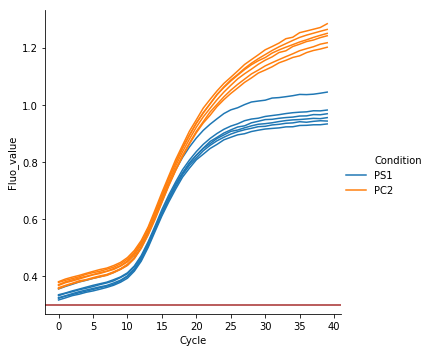

In [5]:
## Plotting several curves 2.0
# Setting the dataset
#fluo_dataset = fluo.loc[(fluo.S_or_C == "PS") & (fluo.Pre_amplification == 0)]
fluo_dataset = fluo.loc[(fluo.Gene == "Bactine2") & ((fluo.Condition == "PS1") | (fluo.Condition == "PC2"))]
#display(fluo.head(2))

# Plotting
sns.relplot(x="Cycle", y="Fluo_value", hue="Condition", units="WellID", estimator=None, kind="line", data=fluo_dataset)
plt.axhline(y=0.3, color="brown")

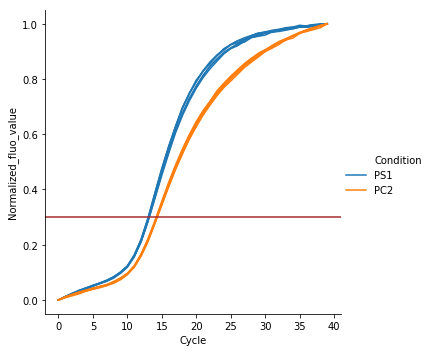

In [6]:
## Plotting several normalized (between 0 and 1) curves 2.0
# Setting the dataset
#fluo_dataset = fluo.loc[(fluo.S_or_C == "PS") & (fluo.Pre_amplification == 0)]
fluo_dataset = norm_fluo.loc[(norm_fluo.Gene == "Bactine2") & ((norm_fluo.Condition == "PS1") | (norm_fluo.Condition == "PC2"))]
#display(fluo.head(2))

# Plotting
sns.relplot(x="Cycle", y="Normalized_fluo_value", hue="Condition", units="WellID", estimator=None, kind="line", data=fluo_dataset)
plt.axhline(y=0.3, color="brown")

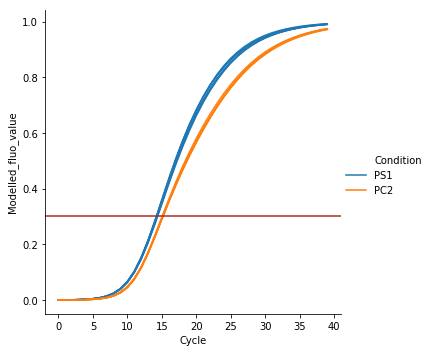

In [8]:
## Plotting several modelled curves 2.0
# Setting the dataset
#fluo_dataset = fluo.loc[(fluo.S_or_C == "PS") & (fluo.Pre_amplification == 0)]
fluo_dataset = mod_fluo.loc[(mod_fluo.Gene == "Bactine2") & ((mod_fluo.Condition == "PS1") | (mod_fluo.Condition == "PC2"))]
#display(mod_fluo.head(2))

# Plotting
sns.relplot(x="Cycle", y="Modelled_fluo_value", hue="Condition", units="WellID", estimator=None, kind="line", data=fluo_dataset)
plt.axhline(y=0.3, color="brown")

/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Assay Sample Cycle  Bkg_norm_fluo_value
300      13     50     0            -0.003748
8076     13      1     0             0.000962
9516     13     50     1            -0.003381
17292    13      1     1             0.001936
18732    13     50     2            -0.003502

TypeError: data type not understood

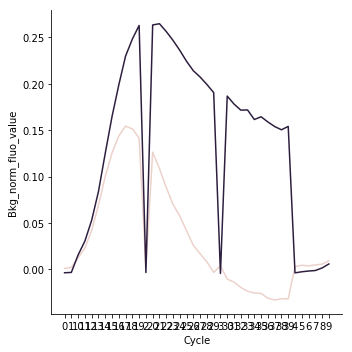

In [32]:
## Plotting the background normalized curves 2.0
# Setting the dataset
#fluo_dataset = fluo.loc[(fluo.S_or_C == "PS") & (fluo.Pre_amplification == 0)]
fluo_dataset = bkg_norm_fluo.loc[((bkg_norm_fluo.Sample == 1) & (bkg_norm_fluo.Assay == 13)) |
                                 ((bkg_norm_fluo.Sample == 50) & (bkg_norm_fluo.Assay == 13))]
fluo_dataset["Sample"] = fluo_dataset.Sample.astype("category")
display(fluo_dataset.head())

# Plotting
sns.relplot(x="Cycle", y="Bkg_norm_fluo_value", hue="Sample", estimator=None, kind="line", data=fluo_dataset)
plt.axhline(y=0.3, color="brown")

In [44]:
import numpy as np

array_size=9216
sample_size=2
df = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/1362243513_fixed_HiFitMB.csv", usecols=[0, 1, 4, 6], skiprows=1, nrows=sample_size, names=["WellID", "Condition", "Gene", "Fluidigm_Ct"])
F = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/1362243513_fixed_HiFitMB.csv",
                skiprows=array_size+4, nrows=sample_size, header=None, sep=",", names=list(range(40)))
display(df)
display(F)
df2 = df.join(F)
display(df2[list(range(40))].min(axis=1))
fluo_per_cyle = pd.melt(df2, id_vars=["WellID", "Condition", "Gene", "Fluidigm_Ct"], value_vars=list(range(40)), var_name="Cycle", value_name="Fluo")
display(fluo_per_cyle.head())

WellID Condition     Gene  Fluidigm_Ct
0  S01-A01       PS1  RPL13a1     8.491106
1  S01-A02       PS1  RPL13a1     8.375671

0         1         2         3         4         5         6   \
0  0.370476  0.375293  0.379359  0.384355  0.390125  0.395933  0.401709   
1  0.351437  0.359487  0.363358  0.368100  0.374405  0.380636  0.387685   

         7         8         9   ...        30        31        32        33  \
0  0.411591  0.424798  0.444080  ...  1.082936  1.091343  1.093735  1.099976   
1  0.397087  0.411649  0.438175  ...  1.128257  1.135592  1.145927  1.146932   

         34        35        36        37       38        39  
0  1.103117  1.105738  1.110323  1.114438  1.11796  1.119182  
1  1.153027  1.155100  1.160351  1.166274  1.16749  1.171007  

[2 rows x 40 columns]

0    0.370476
1    0.351437
dtype: float64

WellID Condition     Gene  Fluidigm_Ct Cycle      Fluo
0  S01-A01       PS1  RPL13a1     8.491106     0  0.370476
1  S01-A02       PS1  RPL13a1     8.375671     0  0.351437
2  S01-A01       PS1  RPL13a1     8.491106     1  0.375293
3  S01-A02       PS1  RPL13a1     8.375671     1  0.359487
4  S01-A01       PS1  RPL13a1     8.491106     2  0.379359

Unnamed: 0   WellID Condition     Gene  Fluidigm_Ct  Sample  Assay  \
0           3  S01-A01       PS1  RPL13a1     8.491106       1      1   
1          11  S01-A02       PS1  RPL13a1     8.375671       1      2   

         F0        F1        F2  ...  P_d_Gompertz_with_bump  \
0  0.370476  0.375293  0.379359  ...               14.360953   
1  0.351437  0.359487  0.363358  ...               21.902514   

   P_e_Gompertz_with_bump  P_f_Gompertz_with_bump  \
0               -0.667781               -0.010595   
1               -0.601157               -0.007973   

   P_a_final_Gompertz_with_bump  P_b_final_Gompertz_with_bump  \
0                      0.847172                      1.478712   
1                      0.765910                      1.444337   

   P_c_final_Gompertz_with_bump  P_d_final_Gompertz_with_bump  \
0                      0.211963                     13.526734   
1                      0.210155                     13.507058   

   P_e_final_Gompertz_with_bump  P_f_final_Gompertz_with_bump  \
0                     -0.473859                     -0.007490   
1                     -0.412447                     -0.011007   

   RSS_Gompertz_with_bump  
0                0.000301  
1                0.000444  

[2 rows x 129 columns]

0.0047098746008161045 0.001985764282102239 0.0037089691718903677 0.003237522928426111 0.004298855495249573 0.0004681445632057035


WellID  Sigmoid_curve  RSS_Gompertz_with_bump
503   S06-A24          False                0.012775
544   S06-A65          False                0.007231
4762  S50-A59           True                0.006059
2454  S26-A55           True                0.005877
4761  S50-A58           True                0.005798
4664  S49-A57           True                0.005740
4760  S50-A57           True                0.005670
2553  S27-A58           True                0.005622
2456  S26-A57           True                0.005484
4759  S50-A56           True                0.005440
8216  S86-A57           True                0.005416
8218  S86-A59           True                0.005409
2455  S26-A56           True                0.005354
2552  S27-A57           True                0.005338
2457  S26-A58           True                0.005326
4763  S50-A60           True                0.005320
4663  S49-A56           True                0.005261
4665  S49-A58           True                0.005259
2555  S27-A60           True                0.005258
8215  S86-A56           True                0.005210
4662  S49-A55           True                0.005168
2551  S27-A56           True                0.005160
4666  S49-A59           True                0.005143
8214  S86-A55           True                0.005123
2458  S26-A59           True                0.005107
8217  S86-A58           True                0.005084
5814  S61-A55           True                0.005055
5819  S61-A60           True                0.005011
2554  S27-A59           True                0.004976
2459  S26-A60           True                0.004973
...       ...            ...                     ...
3586  S38-A35          False                0.000012
2913  S31-A34          False                0.000012
1168  S13-A17          False                0.000012
9112  S95-A89          False                0.000012
3682  S39-A35          False                0.000012
4736  S50-A33          False                0.000012
3488  S37-A33          False                0.000012
4162  S44-A35          False                0.000012
1170  S13-A19          False                0.000012
4531  S48-A20          False                0.000011
1172  S13-A21          False                0.000011
3489  S37-A34          False                0.000011
666   S07-A91          False                0.000011
5494  S58-A23          False                0.000011
4640  S49-A33          False                0.000011
3585  S38-A34          False                0.000011
6079  S64-A32          False                0.000011
4366  S46-A47          False                0.000010
4532  S48-A21          False                0.000010
5643  S59-A76          False                0.000010
3971  S42-A36          False                0.000010
3066  S32-A91          False                0.000010
4365  S46-A46          False                0.000010
1204  S13-A53          False                0.000009
1175  S13-A24          False                0.000008
1174  S13-A23          False                0.000008
1173  S13-A22          False                0.000008
5466  S57-A91          False                0.000008
3679  S39-A32          False                0.000007
5642  S59-A75          False                0.000007

[9216 rows x 3 columns]

0.006860202462618622 0.0029123123693245655 0.004728193308444724 0.004668099568052739 0.006130733847625876 0.0006675628510503234


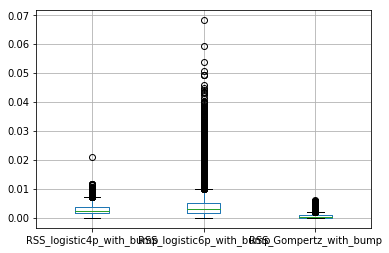

In [13]:
## Diplaying several model RSS distributions
import pandas as pd
import seaborn as sns
import numpy as np
import string

#filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/final_data_Gompertz_with_without_Croquette.tsv"
#filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/final_data_4p_comparison.tsv"
#filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/final_data.tsv"
filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/final_data.logistic4p_logistic6p_Gompertz.without_with_bump.tsv"
#filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/Test/final_data.new_bounds.tsv"
#filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/Test/final_data.logistic6p.tsv"
#filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/Test/final_data.logistic6p_with_bump.tsv"
#filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/Test/final_data.Gompertz_with_bump.tsv"
#filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/Test/final_data.logistic4p_f_with_bump.tsv"
df = pd.read_csv(filepath, sep="\t")
display(df.head(2))

item_nb = 3
first = ["RSS_"] * item_nb
letter = "b"
#first = ["P_" + letter] * item_nb
#first = ["P_" + letter + "_" for letter in list(string.ascii_lowercase)[0:item_nb]]
#second = ["logistic6p"] * item_nb
second = ["logistic4p", "logistic6p", "Gompertz"]
#third = [""] * item_nb
third = ["_with_bump"] * item_nb
cols = [f + s + t for f, s, t in zip(first, second, third)]
#df.boxplot(column=cols)
#print(df.RSS_Gompertz_4p.mean(), df.RSS_Gompertz_4p_with_bump.mean(), df.RSS_Croquette.mean())
#print(df.RSS_logistic4p.mean(), df.RSS_logistic4p_f.mean(), df.RSS_logistic4p_g.mean(), df.RSS_logistic4p_h.mean())
#print(df.RSS_logistic4p_with_bump.mean(), df.RSS_logistic4p_f_with_bump.mean(), df.RSS_logistic4p_g_with_bump.mean(), df.RSS_logistic4p_h_with_bump.mean())
print(df.RSS_logistic4p.mean(), df.RSS_logistic4p_with_bump.mean(), df.RSS_logistic6p.mean(), df.RSS_logistic6p_with_bump.mean(), df.RSS_Gompertz.mean(), df.RSS_Gompertz_with_bump.mean())
#display(df.loc[df["RSS_Gompertz_with_bump"].idxmax()])
display(df[["WellID", "Sigmoid_curve", "RSS_Gompertz_with_bump"]].sort_values(by=["RSS_Gompertz_with_bump"], ascending=False))
#display(df[["WellID", "Sigmoid_curve", "RSS_logistic6p_with_bump"]].sort_values(by=["RSS_logistic6p_with_bump"], ascending=False))
df2 = df.loc[df.Sigmoid_curve]
df2.boxplot(column=cols)
print(df2.RSS_logistic4p.mean(), df2.RSS_logistic4p_with_bump.mean(), df2.RSS_logistic6p.mean(), df2.RSS_logistic6p_with_bump.mean(), df2.RSS_Gompertz.mean(), df2.RSS_Gompertz_with_bump.mean())

WellID Condition     Gene  Fluidigm_Ct  Sample  Assay  \
0   S01-A01       PS1  RPL13a1     8.491106       1      1   
39  S01-A02       PS1  RPL13a1     8.375671       1      2   

                                                 Fluo  Min_fluo  Max_fluo  \
0   [0.37047587131367293, 0.3752927400468384, 0.37...  0.370476  1.119182   
39  [0.3514369012911287, 0.35948692320506415, 0.36...  0.351437  1.171007   

    Amplitude  ...  Ct_fluo_0.3  Nt_log10_0.3 Ct_fluo_0.4  Nt_log10_0.4  \
0    0.748706  ...         14.0     10.274079        15.0     10.559794   
39   0.819570  ...         13.0      9.988365        15.0     10.559794   

    Ct_fluo_0.5  Nt_log10_0.5  Ct_fluo_0.6  Nt_log10_0.6  Ct_fluo_0.7  \
0          17.0     11.131222         18.0     11.416936         20.0   
39         16.0     10.845508         18.0     11.416936         20.0   

    Nt_log10_0.7  
0      11.988365  
39     11.988365  

[2 rows x 39 columns]

/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


WellID Condition     Gene  Fluidigm_Ct  Sample  Assay  \
0   S01-A01       PS1  RPL13a1     8.491106       1      1   
39  S01-A02       PS1  RPL13a1     8.375671       1      2   

                                                 Fluo  Min_fluo  Max_fluo  \
0   [0.37047587131367293, 0.3752927400468384, 0.37...  0.370476  1.119182   
39  [0.3514369012911287, 0.35948692320506415, 0.36...  0.351437  1.171007   

    Amplitude  ...  Ct_fluo_0.3  Nt_log10_0.3 Ct_fluo_0.4  Nt_log10_0.4  \
0    0.748706  ...         14.0     10.274079        15.0     10.559794   
39   0.819570  ...         13.0      9.988365        15.0     10.559794   

    Ct_fluo_0.5  Nt_log10_0.5  Ct_fluo_0.6  Nt_log10_0.6  Ct_fluo_0.7  \
0          17.0     11.131222         18.0     11.416936         20.0   
39         16.0     10.845508         18.0     11.416936         20.0   

    Nt_log10_0.7  
0      11.988365  
39     11.988365  

[2 rows x 39 columns]

Nt_fluo     Gene Condition   Ft
0   10.274079  RPL13a1       PS1  0.3
39   9.988365  RPL13a1       PS1  0.3

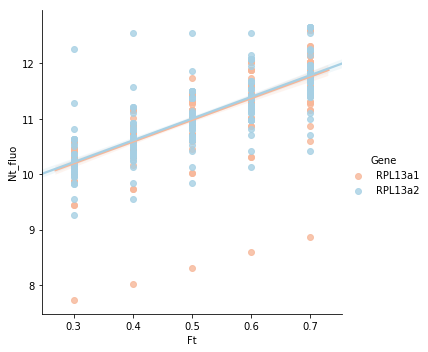

In [26]:
import seaborn as sns

def compute_Nt(df, level):
    df.loc[:, "Ct_fluo_" + str(level)] = df.apply(lambda row: float(np.abs(np.array(row.Modelled_fluo) - level).argmin()), axis=1)
    df.loc[:, "Nt_log10_" + str(level)] = df.apply(lambda row: np.log10(row.Theoretical_N0 * np.power(1 + gene_efficiencies.loc[row.Gene, "Our_method_E"], row["Ct_fluo_" + str(level)])), axis=1)
    return df

def create_level_df(df, level):
    new_df = df[["Nt_log10_" + str(level), "Gene", "Condition"]].copy()
    new_df["Ft_" + str(level)] = level
    new_df.columns = ["Nt_fluo", "Gene", "Condition", "Ft"]
    return new_df

#dataset = data_not_preamp.loc[(data_not_preamp.Gene == "RPL13a1") | (data_not_preamp.Gene == "RPL13a2")]
dataset = data_not_preamp.loc[(data_not_preamp.Gene == "RPL13a1") | (data_not_preamp.Gene == "RPL13a2")]
#dataset = data_not_preamp
#dataset = data_not_preamp[data_not_preamp["Condition"].isin(["PS1", "PS2", "PS3", "PS4", "PS5", "PS6"])]
display(data_not_preamp.head(2))
#dataset = data_not_preamp[(data_not_preamp.S_or_C == "PS") & (data_not_preamp.Dilution <= 6)].copy()
#dataset = data_not_preamp[data_not_preamp.Dilution <= 4].copy()
dataset = compute_Nt(dataset, 0.3)
dataset = compute_Nt(dataset, 0.4)
dataset = compute_Nt(dataset, 0.5)
dataset = compute_Nt(dataset, 0.6)
dataset = compute_Nt(dataset, 0.7)
display(dataset.head(2))

dataset_03 = create_level_df(dataset, 0.3)
dataset_04 = create_level_df(dataset, 0.4)
dataset_05 = create_level_df(dataset, 0.5)
dataset_06 = create_level_df(dataset, 0.6)
dataset_07 = create_level_df(dataset, 0.7)
df = pd.concat([dataset_03, dataset_04, dataset_05, dataset_06, dataset_07])
display(df.head(2))

sns.lmplot(x="Ft", y="Nt_fluo", hue="Gene", data=df, palette="RdBu")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [1]:
## MCV toy dataset for lineplot FacetGrid 2.0
import pandas as pd
import numpy as np
import seaborn as sns

# Building the Minimal, Complete and Verifiable dataset
genes = pd.Series(["Gene1"] * 16 + ["Gene2"] * 16)
conditions = pd.Series(np.tile(np.array(["Condition1"] * 8 + ["Condition2"] * 8), 2))
wellID = pd.Series(np.array(["W1"] * 4 + ["W2"] * 4 + ["W3"] * 4 + ["W4"] * 4 + ["W5"] * 4 + ["W6"] * 4 + ["W7"] * 4 + ["W8"] * 4))
fluo = pd.Series(np.array([np.sort(np.random.logistic(size=4)) for _ in range(8)]).flatten())
cycles = pd.Series(np.tile(np.array([0, 1, 2, 3]), 8))
df = pd.concat([genes, conditions, wellID, cycles, fluo], axis=1)
df.columns = ["Gene", "Condition", "WellID", "Cycle", "Fluo"]
display(df.head())

# Plotting
#sns.lineplot(x="Cycle", y="Fluo", hue="Condition", units="WellID", estimator=None, data=df[df.Gene == "Gene1"])
g = sns.FacetGrid(df, col="Gene", hue="Condition", col_wrap=5)
g.map_dataframe(sns.lineplot, "Cycle", "Fluo", units="WellID", estimator=None);

Gene   Condition WellID  Cycle      Fluo
0  Gene1  Condition1     W1      0 -1.781291
1  Gene1  Condition1     W1      1 -1.729287
2  Gene1  Condition1     W1      2 -1.156267
3  Gene1  Condition1     W1      3  0.832292
4  Gene1  Condition1     W2      0 -0.870832

In [2]:
## Loading data
import re
import os
import pandas as pd

# General path variables
f = "rtgo_raw_141209.csv"#"rtsensi_raw_150113.csv"#"rthc_raw_141210.csv"#"rtgo_raw_141209.csv"
path = "/users/biocomp/bahin/Python_virtual_env/Env_HiFit/bin/"
filename = re.sub('.csv', '', f, flags=re.IGNORECASE)

# Loading LRE computed F0 values
LRE = pd.read_csv(os.path.join(path, "script_results/", filename + "_LRE.MB.csv"), header=0, usecols=["ID", "Sample", "Gene", "LRE_F0"])
LRE.columns = ["ID", "Sample", "Gene", "F0"]
LRE["Method"] = "LRE"
#print LRE.shape
#print LRE.head(2)
# Filtering LRE computed F0 values to get only PS1-6 samples and not "Cyp26a1" gene that didn't work
LRE_PS = LRE[LRE.Sample.str.match("^PS[0-9]*")]
LRE_PS1_6 = LRE_PS[(LRE_PS["Sample"] != "PS7") & (LRE_PS["Sample"] != "PS8") & (LRE_PS["Sample"] != "PS9") & (LRE_PS["Sample"] != "PS10") & (LRE_PS["Sample"] != "PS11") & (LRE_PS["Sample"] != "PS12") & (LRE_PS["Gene"] != "Cyp26a1")]
#print LRE_PS1_6.head(2)

# Loading HiFit computed F0 values
HiFit = pd.read_csv(os.path.join(path, "script_results/", filename + "result.MB.csv"), header=0, usecols=["ID", "Sample", "Gene", "HiFit_F0"])
HiFit.columns = ["ID", "Sample", "Gene", "F0"]
HiFit["Method"] = "HiFit"
#print HiFit.shape
#print HiFit.head(2)
# Filtering HiFit computed F0 values to get only PS1-6 samples and not "Cyp26a1" gene that didn't work
HiFit_PS = HiFit[HiFit.Sample.str.match("^PS[0-9]*")]
HiFit_PS1_6 = HiFit_PS[(HiFit_PS["Sample"] != "PS7") & (HiFit_PS["Sample"] != "PS8") & (HiFit_PS["Sample"] != "PS9") & (HiFit_PS["Sample"] != "PS10") & (HiFit_PS["Sample"] != "PS11") & (HiFit_PS["Sample"] != "PS12") & (LRE_PS["Gene"] != "Cyp26a1")]
#print HiFit_PS1_6.head(2)

# Merging method DataFrames
all_methods_PS1_6 = pd.concat([LRE_PS1_6, HiFit_PS1_6])
all_methods_PS1_6 = all_methods_PS1_6.sort_values("ID")
#print all_methods_PS1_6.shape
#print all_methods_PS1_6.head(2)

# Loading real concentrations values
real_N0 = pd.read_csv(path + "real_concentration.csv", header=0, index_col=0)
reshaped_real_N0 = real_N0.reset_index()
reshaped_real_N0.rename(columns={"index": "Sample"}, inplace=True)
reshaped_real_N0 = pd.melt(reshaped_real_N0, id_vars="Sample", var_name="Gene", value_name="N0")
#print reshaped_real_N0.head(2)

# Adding N0 info
all_methods_PS1_6_N0 = pd.merge(all_methods_PS1_6, reshaped_real_N0, how="left", on=["Sample", "Gene"])
#print all_methods_PS1_6_N0.head(2)

# Loading the fluo data
fluo = pd.read_csv("/users/biocomp/bahin/Python_virtual_env/Env_HiFit/bin/rtgo_raw_141209.fluo.csv", index_col=0, header=None)
# Wrapping the 40 fluo values into a list and keeping only this column
fluo["fluo_list"] = [[] for _ in range(len(fluo))] # Useful but why??
for index, row in fluo.iterrows():
    fluo.set_value(index, "fluo_list", row.tolist())
#print fluo.shape
print fluo.head(2)

IOError: File /users/biocomp/bahin/Python_virtual_env/Env_HiFit/bin/script_results/rtgo_raw_141209_LRE.MB.csv does not exist

(-0.005, 0.03)

/users/biocomp/bahin/Python_virtual_env/Env_HiFit/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


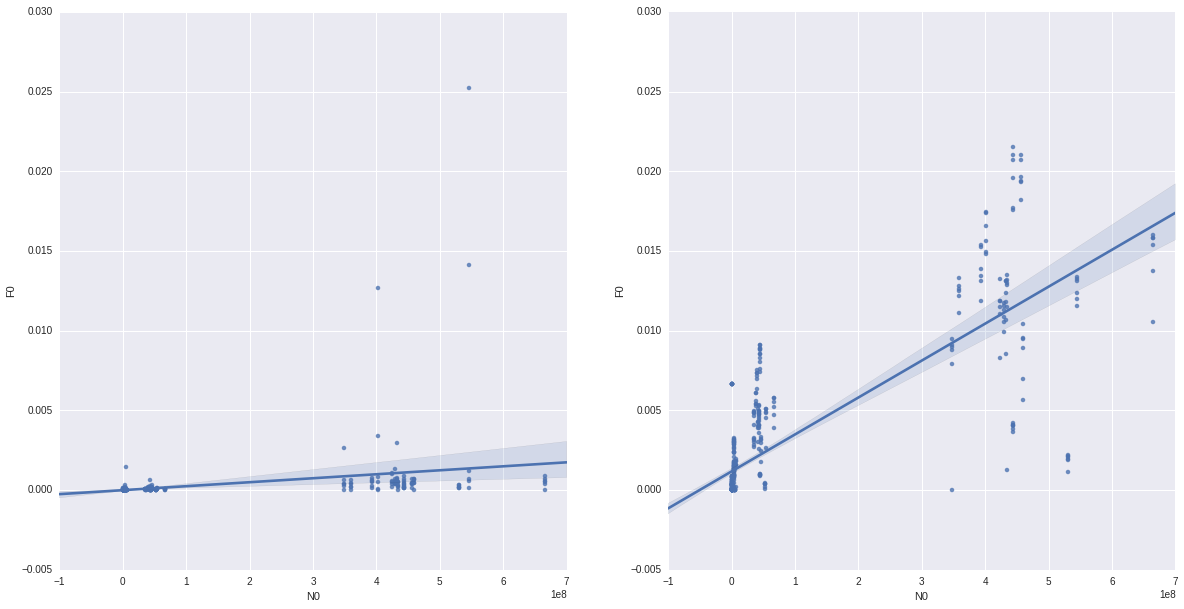

In [23]:
## Plotting regplots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(20, 10))
plt.subplot(121)
ax = sns.regplot(x="N0", y="F0", data=all_methods_PS1_6_N0[all_methods_PS1_6_N0["Method"] == "LRE"])
plt.subplot(122)
ax = sns.regplot(x="N0", y="F0", data=all_methods_PS1_6_N0[all_methods_PS1_6_N0["Method"] == "HiFit"])
ax.set_ylim(-0.005, 0.030)

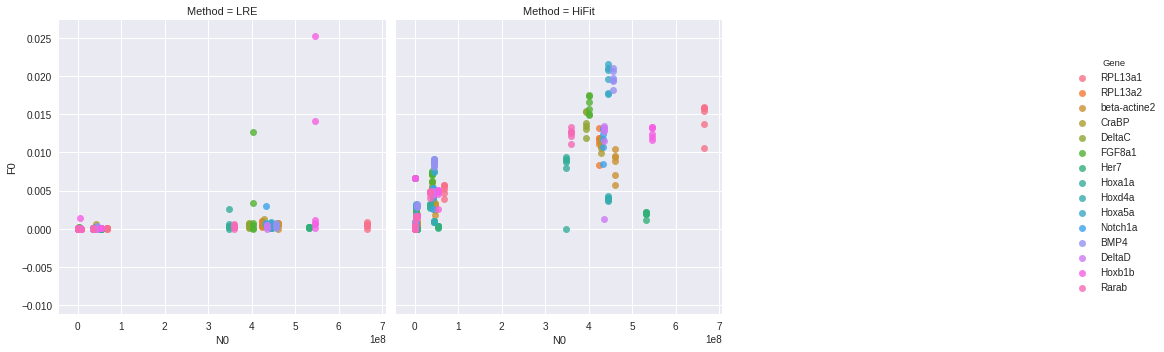

In [7]:
## Plotting regplots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Lmplot for 1 sample
#plt.figure()
#ax = sns.lmplot(x="N0", y="F0", data=all_methods_PS1_6_N0[all_methods_PS1_6_N0["Sample"] == "PS6"], col="Method", hue="Sample")

# Lmplot for Samples
#plt.figure()
#ax = sns.lmplot(x="N0", y="F0", data=all_methods_PS1_6_N0, col="Sample", row="Method", hue="Sample")

# Lmplot for Samples
plt.figure()
ax = sns.lmplot(x="N0", y="F0", data=all_methods_PS1_6_N0, col="Method", hue="Gene", col_wrap=3, fit_reg=False)
axes = ax.axes
#axes[0].set_ylim(0,0.0015)
#ax = sns.lmplot(x="N0", y="F0", data=all_methods_PS1_6_N0[all_methods_PS1_6_N0["Method"] == "LRE"], col="Gene", hue="Gene", col_wrap=5)
#ax = sns.lmplot(x="N0", y="F0", data=all_methods_PS1_6_N0[all_methods_PS1_6_N0["Method"] == "HiFit"], col="Gene", hue="Gene", col_wrap=5)

0
S02-A28    [0.389443743478, 0.395138048222, 0.40051194247...
Name: fluo_list, dtype: object


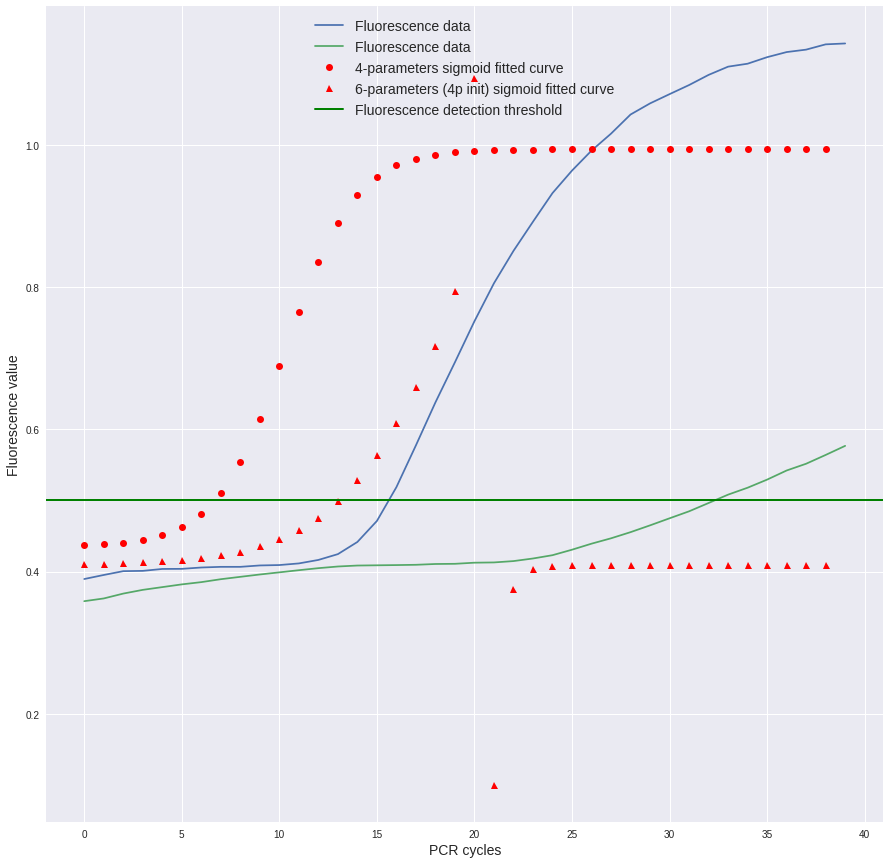

In [11]:
## Display a curve
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

d = fluo[fluo.index.str.contains("S02-A28")]["fluo_list"]
#e = fluo[fluo.index.str.contains("S14-A46")]["fluo_list"]
e = fluo[fluo.index.str.contains("S40-A18")]["fluo_list"]
print d

p4 = []
for i in range(1,40):
    #p4.append(logistic4parameters(i, 0.12, 1.2, 0.03, 1.22))
    #p4.append(logistic4parameters(i, 0.44, 0.97, 0.53, 2.13))
    #p4.append(logistic4parameters(i, 0.4086, 1.1196, 0.0005, 1.3924))
    p4.append(logistic4parameters(i, 0.435, 0.994, 0.001, 1.747))

"""
p6 = []
for i in range(1,40):
    p6.append(logistic6parameters(i, 0.5147, 0.9743, 0.5549, 1.8937, 0.1040, -77.4728))   
"""

p6_2 = []
for i in range(1,40):
    #p6_2.append(logistic6parameters(i, 0.10, 1.2, 0.03, 1.22, 0.2, 0.6))
    #p6_2.append(logistic6parameters(i, 0.4843, 1.1580, 0.0001, 1.7862, -0.7258, -19.4839))
    #p6_2.append(logistic6parameters(i, 0.4086, 0.8509, 0.0654, 1.7041, -0.3938, -86.6509))
    #p6_2.append(logistic6parameters(i, 0.4086, 0.8509, 0.0001, 1.5112, -0.2731, -0.0543))
    #p6_2.append(logistic6parameters(i, 0.420, 0.447, 0.001, 1.572, -0.377, -91.370))
    p6_2.append(logistic6parameters(i, 0.409, 1.120, 0.001, 1.392, -0.528, -5.350))
    
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
for l in d:
    #plt.plot(l[:-1])
    ax.plot(l[:-1], label="Fluorescence data")
for l in e:
    ax.plot(l[:-1], label="Fluorescence data")
ax.plot(p4, "ro", label="4-parameters sigmoid fitted curve")
#ax.plot(p6, "r-", label="6-parameters sigmoid fitted curve")
ax.plot(p6_2, "r^", label="6-parameters (4p init) sigmoid fitted curve")
plt.xlabel("PCR cycles", fontsize=14)
plt.ylabel("Fluorescence value", fontsize=14)
plt.axhline(y=.5, linewidth=2, color="green", label="Fluorescence detection threshold")
legend = plt.legend(loc="upper center", shadow=True, fontsize=14)

/import/bc_users/biocomp/bahin/Virtual_envs/Env_Hifit/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]


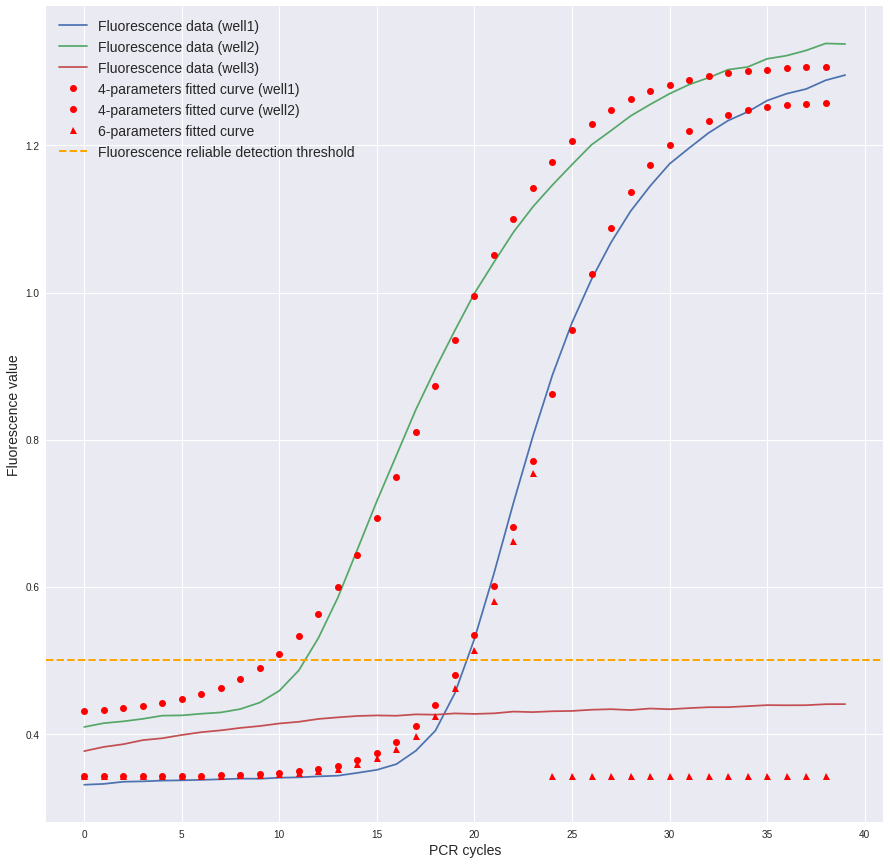

In [2]:
## Display a curve
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Import fluo data
# head -9217 DataFluo3_HiFit.csv | tail -9216 > tmp
# tail -9216 DataFluo3_HiFit.csv > tmp2
# paste -d, tmp tmp2 | cut -f1,8- -d, > tmp3
fluo = pd.read_csv("/data/biocomp/bahin/qPCR/Data/tmp3", index_col=0, header=None)
fluo["fluo_list"] = [[] for _ in range(len(fluo))] # Useful but why??
for index, row in fluo.iterrows():
    fluo.set_value(index, "fluo_list", row.tolist())
#print fluo.loc["S02-A28"]

d = fluo[fluo.index.str.contains("S05-A10") | fluo.index.str.contains("S05-A13") | fluo.index.str.contains("S01-A42")]["fluo_list"]
#print d

s05a10 = []
s05a12 = []
s05a13 = []
for i in range(1,40):
    s05a10.append(logistic4parameters(i, 0.342, 1.261, 0.000056, 1.49)) # S05-A10
    s05a12.append(logistic4parameters(i, 0.250, 0.804, 0.000065, 1.46)) # S05-A12
    s05a13.append(logistic4parameters(i, 0.425, 1.310, 0.004, 1.33)) # S05-A13
    
p6 = []
for i in range(1,40):
    #p6.append(logistic6parameters(i, 0.342, 1.26, 0.000055, 1.49, 0.07, -28))
    p6.append(logistic6parameters(i, 0.342, 1.25, 0.000028, 1.53, 1, -175))

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
i = 0
for l in d:
    i += 1
    #plt.plot(l[:-1])
    ax.plot(l[:-1], label="Fluorescence data (well" + str(i) + ")")
ax.plot(s05a10, "ro", label="4-parameters fitted curve (well1)")
#ax.plot(s05a12, "ro", label="4-parameters fitted curve (well 2)")
ax.plot(s05a13, "ro", label="4-parameters fitted curve (well2)")
ax.plot(p6, "r^", label="6-parameters fitted curve")
plt.xlabel("PCR cycles", fontsize=14)
plt.ylabel("Fluorescence value", fontsize=14)
plt.axhline(y=.5, linewidth=2, color="orange", ls="--", label="Fluorescence reliable detection threshold")
legend = plt.legend(loc="upper left", shadow=True, fontsize=14)

In [9]:
## Fitting models

def logistic4parameters(x, minimum, maximum, F0, E):
    return minimum + (maximum - minimum) / (1 + (((maximum - minimum) / F0) - 1) * (E ** -x))

def logistic6parameters(x, minimum, maximum, F0, E, alpha, beta):
    return minimum + (maximum - minimum) / (1 + ((((maximum - minimum) / F0) - 1) * np.power(E, -x)) + alpha * np.power((F0 * np.power(E, x)), -beta))

In [4]:
def max_likelihood(y, fun, *params):
    """ Compute the maximum likelihood for a function over the value. """
    x = np.array(range(1, len(y) + 1))
    return np.prod((fun(x, *params) ** y) * ((1 - fun(x, *params)) ** (1 - y)))

In [4]:
#fluo_file = "/data/biocomp/bahin/qPCR/Data/DataFluo4_HiFitMB.csv"
#fluo_file = "/data/biocomp/bahin/qPCR/Research_plate/data_HiFitMB.csv"
#fluo_file = "/data/biocomp/bahin/qPCR/Research_plate/Test/data.block2_shuffled_HiFitMB.csv"
fluo_file = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/1362243513_fixed_HiFitMB.csv"

In [5]:
## Loading fluo data
import numpy as np
import pandas as pd

with open(fluo_file, "r") as input_file:
    for i, (d) in enumerate(input_file):
        if "# Infos" in d: # Getting the sample IDs
            sample_IDs = np.genfromtxt(input_file, delimiter=",", usecols=0, max_rows=9216, dtype="string")
        elif "# Fluo" in d: # Getting the fluo data
            fluo_values = np.genfromtxt(input_file, delimiter=",", dtype="float")

# Merging the sample IDs and fluo values
fluo = pd.DataFrame(data=fluo_values, index=sample_IDs)
print(fluo)

TypeError: data type "s" not understood

NameError: name 'fluo' is not defined

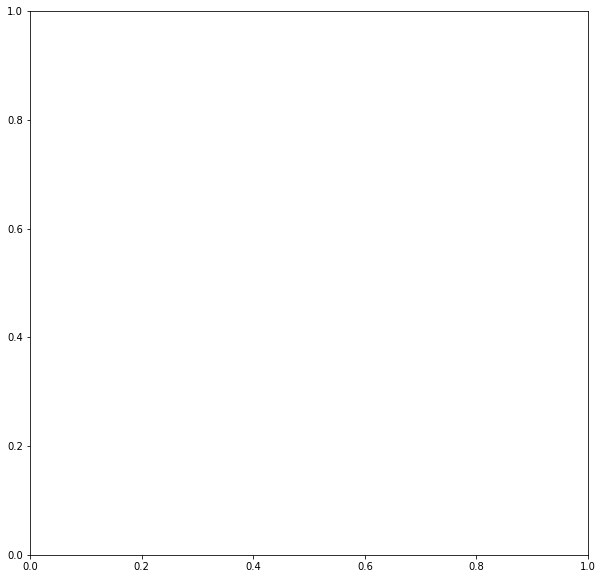

In [6]:
## Displaying one curve and its measures
import matplotlib.pyplot as plt
import sys
%matplotlib inline

# Curve sample ID to display
curve = "S06-A09"

# Plotting the curves
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(fluo.loc[curve], label="Fluorescence data")
ax.plot(derivative(list(fluo.loc[curve])), color="orange", label="Derivative")
ax.plot(second_derivative(list(fluo.loc[curve])), color="pink", label="Second derivative")
axes = plt.gca()
axes.set_ylim(-0.5, 1.7)
plt.xlabel("PCR cycles", fontsize=14)
plt.ylabel("Fluorescence value", fontsize=14)
plt.title(curve)
plt.axhline(y=.5, linewidth=2, color="orange", ls="--", label="Fluorescence reliable detection threshold")
plt.axvline(x=min_second_derivative(list(fluo.loc[curve])), color="yellow", label="Min second derivative")
plt.axvline(x=max_second_derivative(list(fluo.loc[curve])), color="brown", label="Max second derivative")
plt.axvline(x=null_second_derivative(list(fluo.loc[curve])), color="khaki", label="Null second derivative")
legend = plt.legend(loc="upper left", shadow=True, fontsize=14)

In [12]:
## Displaying a curve and its fitting one
import matplotlib.pyplot as plt
import sys
%matplotlib inline

# Curve sample ID to display
curve = "S86-A59"

# Found parameters for the curve
params_4p = []
params_6p = []
#with open("/data/biocomp/bahin/qPCR/results.QV_version.MeanRSS0.tsv", "r") as input_file:
with open("/data/biocomp/bahin/qPCR/results.4p_6p.0.tsv", "r") as input_file:
    for line in input_file:
        if line.split("\t")[0] == curve:
            for p in line.split("\t")[6].lstrip("[").rstrip("]").split(" "):
                try:
                    params_4p.append(float(p.rstrip(",")))
                except ValueError:
                    print "Coucou 4p"
                    pass
            for p in line.split("\t")[8].lstrip("[").rstrip("]").split(" "):
                try:
                    params_6p.append(float(p.rstrip(",")))
                except ValueError:
                    print "Coucou 6p"
                    pass
            break
    else:
        sys.exit("Sample ID not found in the file. Aborting.")
"""
params_4p_2 = []
with open("/data/biocomp/bahin/qPCR/results.QV_version.40RSS.tsv", "r") as input_file:
    for line in input_file:
        if line.split("\t")[0] == curve:
            for p in line.split("\t")[6].lstrip("[").rstrip("]").split(" ")[0:4]:
                try:
                    params_4p_2.append(float(p.rstrip(",")))
                except ValueError:
                    print "Coucou"
                    pass
            break

print "Params1", params_4p
print max_likelihood(fluo.loc[curve], logistic4parameters, *params_4p)
print "Params2", params_4p_2
print max_likelihood(fluo.loc[curve], logistic4parameters, *params_4p_2)
#print params_6p
#print max_likelihood(fluo.loc[curve], logistic6parameters, *params_6p)
"""
# Drawing the fitting curve
fitted_4p = []
fitted_6p = []
#fitted_4p_2 = []
for i in range(0, 40):
    fitted_4p.append(logistic4parameters(i, *params_4p))
    fitted_6p.append(logistic6parameters(i, *params_6p))
    #fitted_4p_2.append(logistic4parameters(i, *params_4p_2))

# Plotting the curves
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
ax.plot(fluo.loc[curve], label="Fluorescence data")
ax.plot(derivative(list(fluo.loc[curve])), color="orange", label="Derivative")
ax.plot(second_derivative(list(fluo.loc[curve])), color="pink", label="Second derivative")
ax.plot(fitted_4p, "ro", label="4-parameters fitted curve", color="purple")
ax.plot(fitted_6p, "ro", label="6-parameters fitted curve", color="green")
#ax.plot(fitted_4p_2, "ro", label="4-parameters fitted curve numero 2", color="green")
axes = plt.gca()
axes.set_ylim(0.2, 1.7)
plt.xlabel("PCR cycles", fontsize=14)
plt.ylabel("Fluorescence value", fontsize=14)
plt.title(curve)
plt.axhline(y=.5, linewidth=2, color="orange", ls="--", label="Fluorescence reliable detection threshold")
plt.axvline(x=min_second_derivative(list(fluo.loc[curve])), color="yellow", label="Min second derivative")
plt.axvline(x=max_second_derivative(list(fluo.loc[curve])), color="brown", label="Max second derivative")
plt.axvline(x=null_second_derivative(list(fluo.loc[curve])), color="khaki", label="Null second derivative")
legend = plt.legend(loc="upper left", shadow=True, fontsize=14)

ZeroDivisionError: float division by zero

Params 4p: [0.38460641206128354, 1.142694999769093, 0.006077171966530876, 1.3315685022491472]
Params 6p: [0.3901700649986644, 1.1693332180230045, 0.029736929106196883, 1.2196211982256462, 0.03192731642004738, 3.733941222524326]


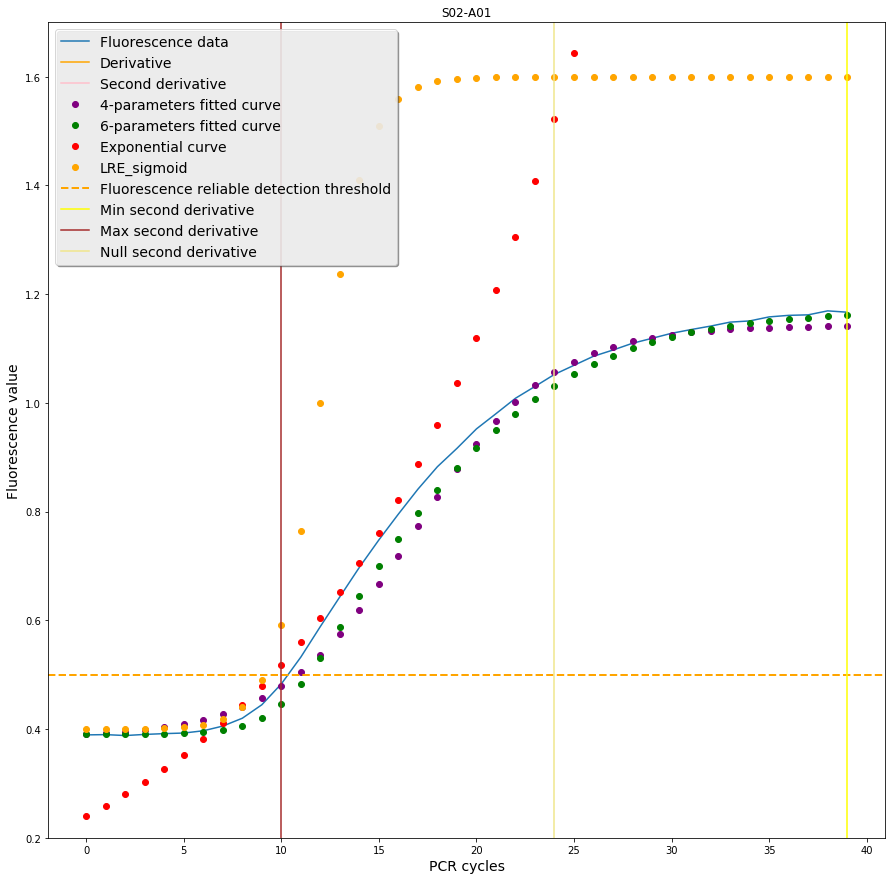

In [47]:
## Displaying a curve and its fitting one
import matplotlib.pyplot as plt
import sys
%matplotlib inline

def exponential(F0, E): # To trash
    res = []
    for x in range(40):
        res.append(F0 * E**x)
    return res

def LRE_sigmoid(x, Fmax, half_Fmax_cycle, E, Fbackground): # To trash
    return (Fmax / (1 + np.exp(-1 * ((x - half_Fmax_cycle) / E)))) + Fbackground

# Curve sample ID to display
curve = "S02-A01"

# Found parameters for the curve
params_4p = []
params_6p = []
#with open("/data/biocomp/bahin/qPCR/results.QV_version.MeanRSS0.tsv", "r") as input_file:
with open("/data/biocomp/bahin/qPCR/results.4p_6p.0.tsv", "r") as input_file:
    for line in input_file:
        if line.split("\t")[0] == curve:
            for p in line.split("\t")[6].lstrip("[").rstrip("]").split(" "):
                try:
                    params_4p.append(float(p.rstrip(",")))
                except ValueError:
                    print "Coucou"
                    pass
            for p in line.split("\t")[8].lstrip("[").rstrip("]").split(" "):
                try:
                    params_6p.append(float(p.rstrip(",")))
                except ValueError:
                    print "Coucou"
                    pass
            break
    else:
        sys.exit("Sample ID not found in the file. Aborting.")

print "Params 4p:", params_4p
print "Params 6p:", params_6p

# Drawing the fitting curve
fitted_4p = []
fitted_6p = []
LRE_sigmoid_values = []
for i in range(0, 40):
    fitted_4p.append(logistic4parameters(i, *params_4p))
    fitted_6p.append(logistic6parameters(i, *params_6p))
    # To trash
    #LRE_sigmoid_values.append(LRE_sigmoid(i, params_4p[1], params_4p[2], params_4p[3], params_4p[0]))
    LRE_sigmoid_values.append(LRE_sigmoid(i, 1.2, 12, 1.2, 0.4))

# Plotting the curves
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
ax.plot(fluo.loc[curve], label="Fluorescence data")
ax.plot(derivative(list(fluo.loc[curve])), color="orange", label="Derivative")
ax.plot(second_derivative(list(fluo.loc[curve])), color="pink", label="Second derivative")
ax.plot(fitted_4p, "ro", label="4-parameters fitted curve", color="purple")
ax.plot(fitted_6p, "ro", label="6-parameters fitted curve", color="green")
ax.plot(exponential(0.24, 1.08), "ro", label="Exponential curve", color="red")
ax.plot(LRE_sigmoid_values, "ro", label="LRE_sigmoid", color="orange") # To trash
axes = plt.gca()
axes.set_ylim(0.2, 1.7)
plt.xlabel("PCR cycles", fontsize=14)
plt.ylabel("Fluorescence value", fontsize=14)
plt.title(curve)
plt.axhline(y=.5, linewidth=2, color="orange", ls="--", label="Fluorescence reliable detection threshold")
plt.axvline(x=min_second_derivative(list(fluo.loc[curve])), color="yellow", label="Min second derivative")
plt.axvline(x=max_second_derivative(list(fluo.loc[curve])), color="brown", label="Max second derivative")
plt.axvline(x=null_second_derivative(list(fluo.loc[curve])), color="khaki", label="Null second derivative")
legend = plt.legend(loc="upper left", shadow=True, fontsize=14)

Text(0.5,1,'18C_PS1 curves')

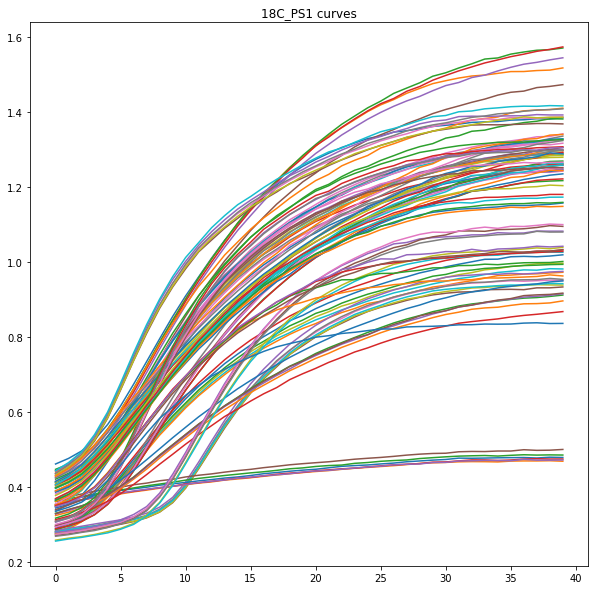

In [25]:
## Display n curve(s) from a list of identifiers in a file
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Setting the filepath
#filepath = "/data/biocomp/bahin/qPCR/Curve_discrimination/Area_under_chord/sigmoid.edge.txt"
filepath = "/data/biocomp/bahin/qPCR/Research_plate/18C_PC1.txt"

# Import sample IDs list to plot
with open(filepath, "r") as flat_file:
    curves = np.genfromtxt(flat_file, dtype="string")

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
for curve in curves:
    ax.plot(fluo.loc[curve])
plt.title("18C_PS1 curves")

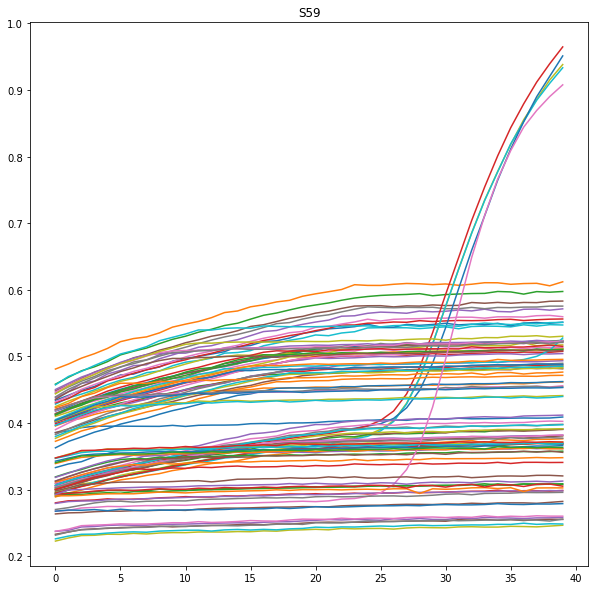

In [15]:
## Display the 96 curves for 1 sample
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def display_sample(sample, name):
    """ Function to display the 96 curves for 1 given sample. """
    ax = plt.subplot(111)
    for assay in range(1,97):
        ax.plot(fluo.loc[sample + "-A{:02d}".format(assay)])
    plt.title(name)

# Setting the sample to display
sample = "S59"

# Displaying the curves
fig = plt.figure(figsize=(10, 10))
display_sample(sample, sample)

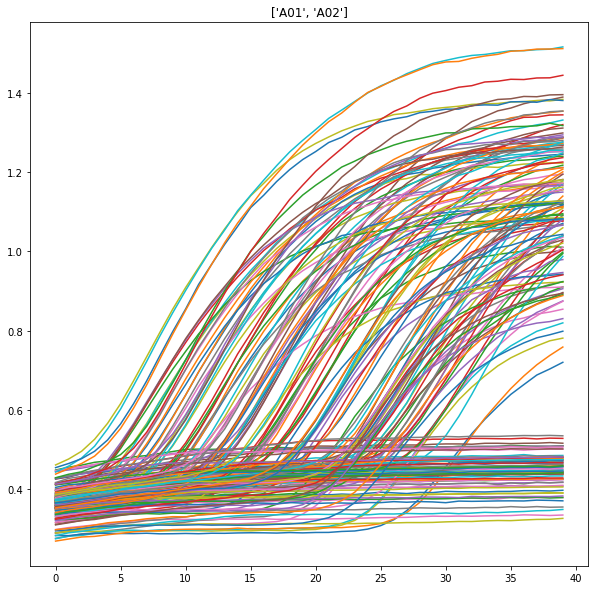

In [20]:
## Display the 96 curves for n assay(s)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def display_assay(assays, name):
    """ Function to display the 96 curves for n given assay(s). """
    ax = plt.subplot(111)
    for sample in range(1,97):
        for assay in assays:
            ax.plot(fluo.loc["S{:02d}".format(sample) + "-" + assay])
    plt.title(name)
    
# Setting the assays to display
assays = ["A01", "A02"]

# Displaying the curves
fig = plt.figure(figsize=(10, 10))
display_assay(assays, assays)

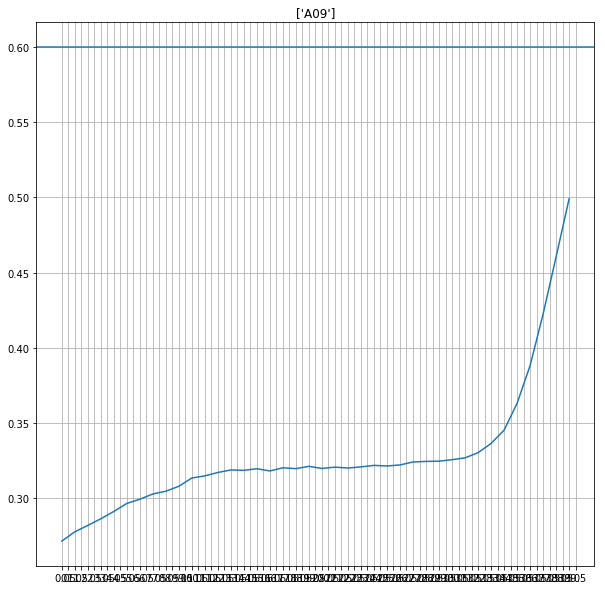

In [42]:
## Display the 96 curves for n assay(s)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def display_assay(assays, name):
    """ Function to display the 96 curves for n given assay(s). """
    ax = plt.subplot(111)
    for sample in samples:
        for assay in assays:
            #ax.plot(fluo.loc["S{:02d}".format(sample) + "-" + assay])
            #ax.plot(pd.Series(data.loc[data.WellID == sample + "-" + assay, "Fluo"].tolist()[0]))
            ax.plot(fluo.loc[sample + "-" + assay])
    xticks = np.arange(0, 40, 0.5)
    ax.set_xticks(xticks)
    ax.axhline(y=0.6)
    ax.grid(True)
    #plt.xlim(11, 13)
    plt.title(name)
    
# Setting the assays to display
#assays = ["A19", "A20", "A21", "A22", "A23", "A24"]
assays = ["A09"]
#samples = ["S49", "S50", "S51", "S52", "S53", "S54", "S55", "S56", "S57", "S58", "S59"]
samples = ["S06"]

# Displaying the curves
fig = plt.figure(figsize=(10, 10))
display_assay(assays, assays)

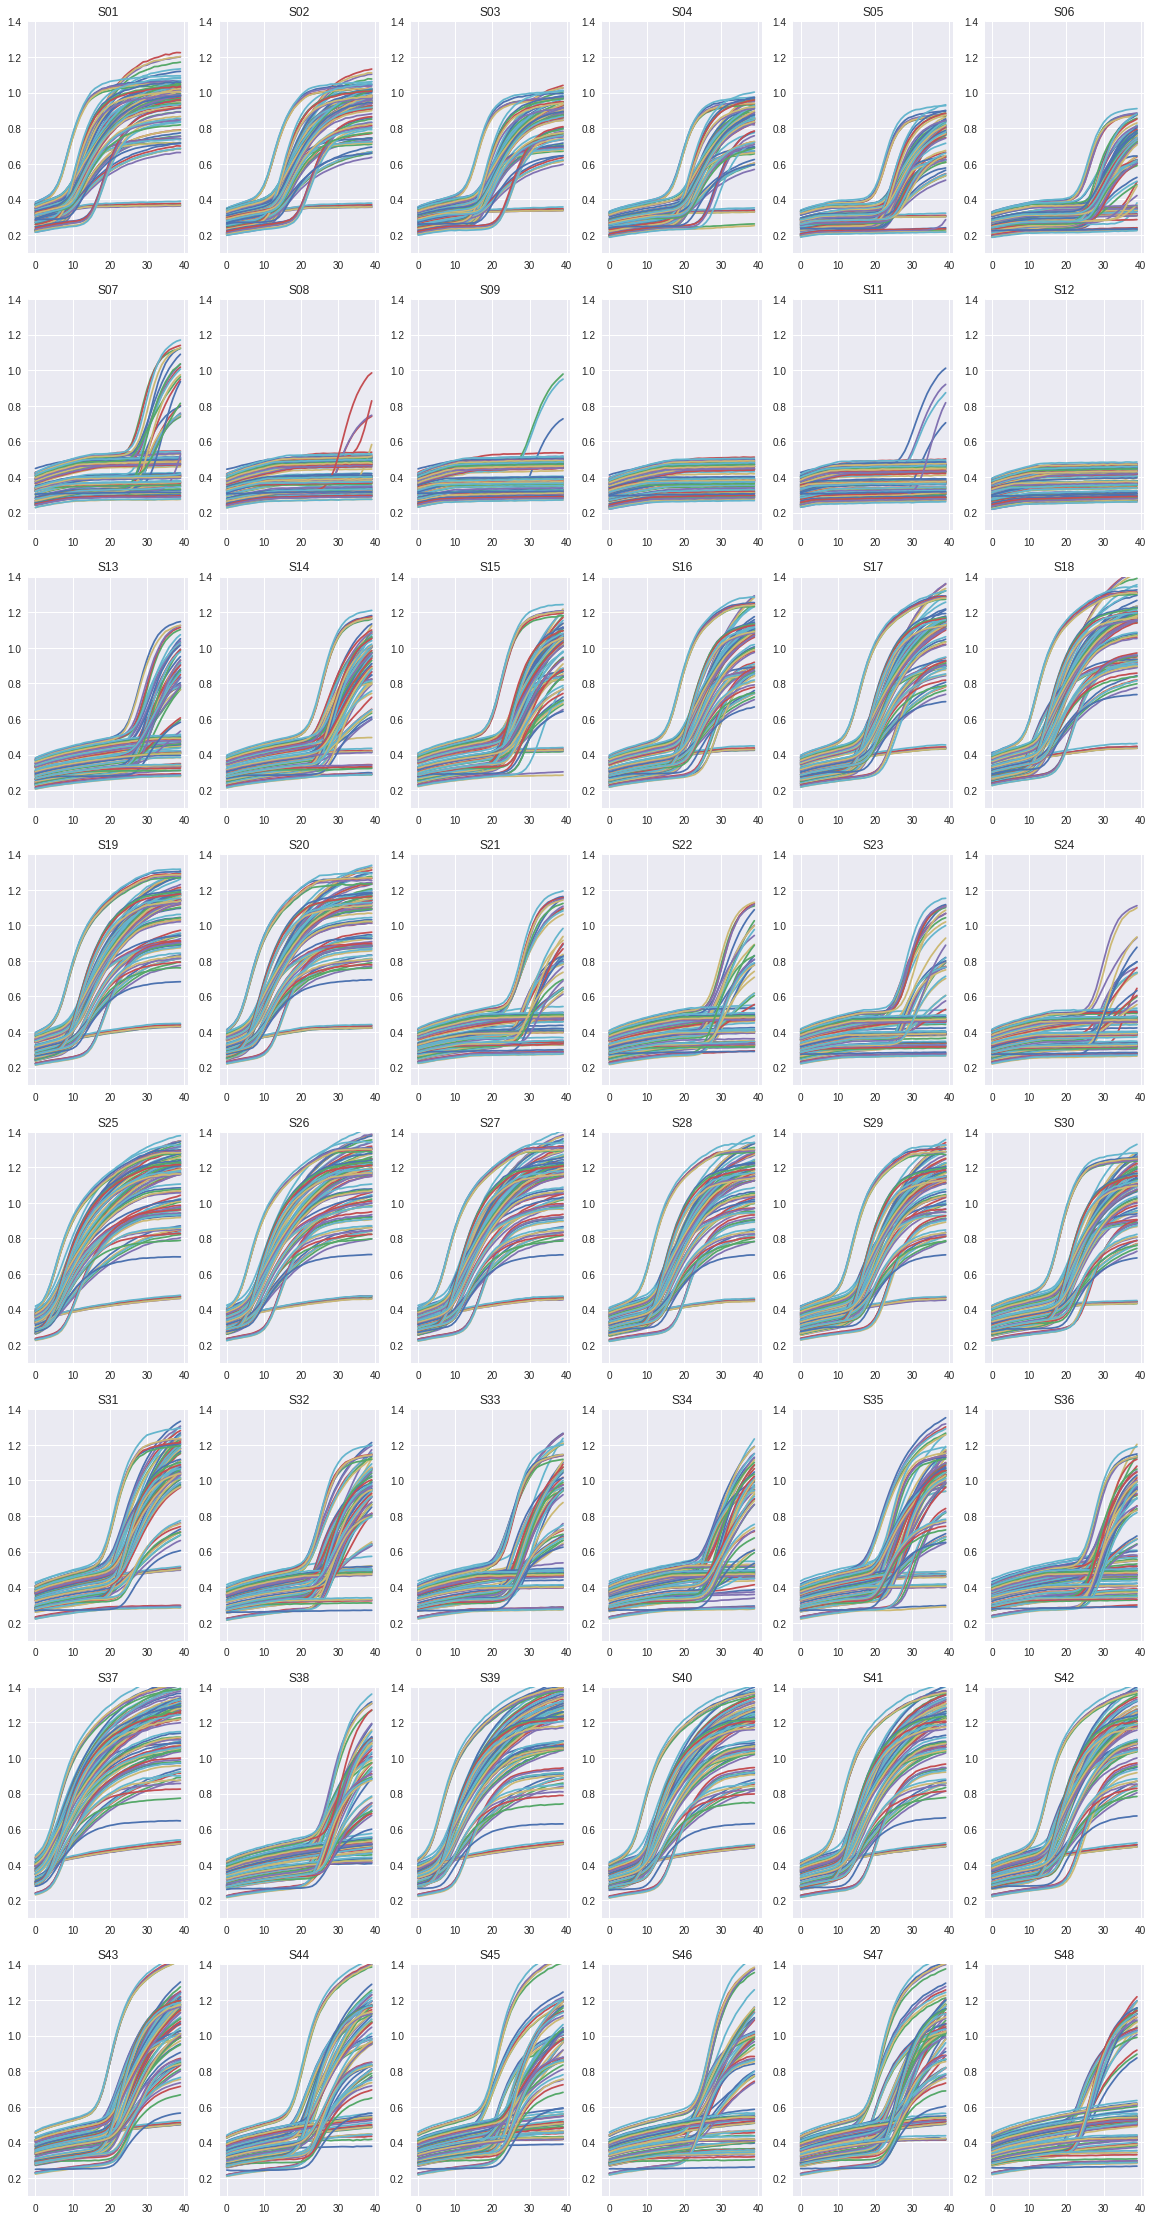

In [16]:
## Display the 96 curves for 1 sample
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def display_sample(sample, name, location):
    """ Function to display the 96 curves for 1 given sample. """
    ax = plt.subplot(nrows, n_plot_row, nb_sample)
    for assay in range(1,97):
        ax.plot(fluo.loc[sample + "-A{:02d}".format(assay)])
        axes = plt.gca()
        axes.set_ylim(0.1, 1.4)
    plt.title(name)

# Setting the range of curves to display (start and end)
start = 1
end = 49

# Setting the number of plot per row
n_plot_row = 6

# Displaying the curves
samples = range(start, end)  # Range of samples
nb_samples = range(1, end - start + 1)  # Range of samples starting at 1
nrows = int(math.ceil(float(len(samples)) / n_plot_row))  # Number of rows of n_plot_row plots
fig = plt.figure(figsize=(20, 5 * nrows))
for sample, nb_sample in zip(samples, nb_samples):
    display_sample("S" + "{:02d}".format(sample), "S" + "{:02d}".format(sample), nb_sample)

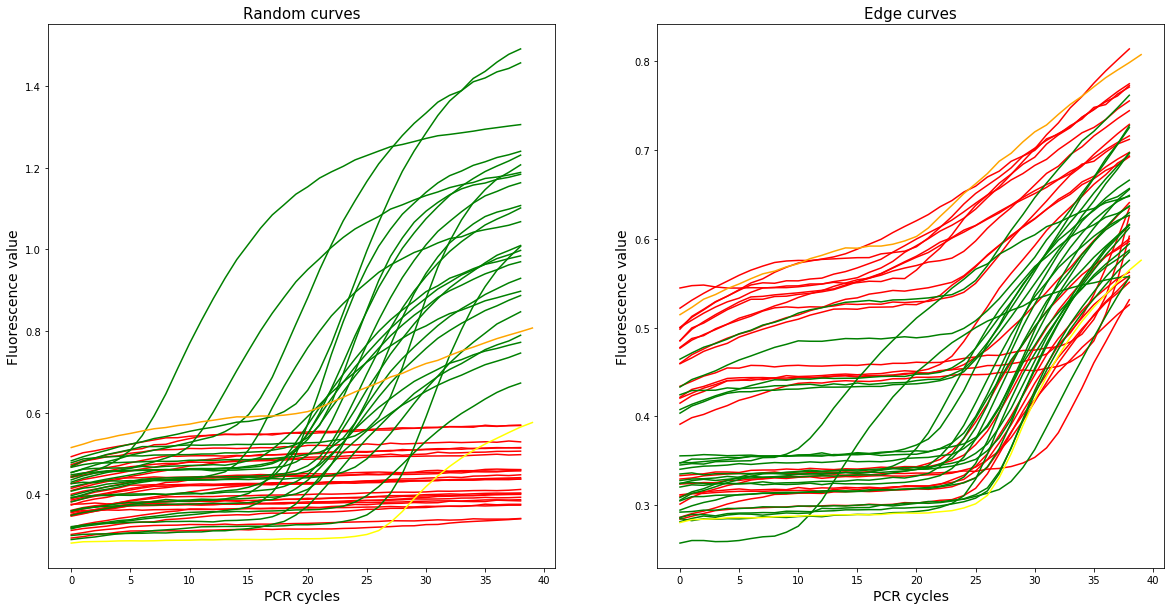

In [67]:
## Display the random and the edges curves
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Setting the initial directory
#init_dir = "/data/biocomp/bahin/qPCR/Curve_discrimination/Area_under_chord/"
#init_dir = "/data/biocomp/bahin/qPCR/Research_plate/"
init_dir = "/data/biocomp/bahin/qPCR/Data_fluo4/"

# Import sample IDs list to plot
with open(init_dir + "flat.random.txt", "r") as flat_file:
    flat_random = np.genfromtxt(flat_file, dtype="string")
with open(init_dir + "sigmoid.random.txt", "r") as sigmoid_file:
    sigmoid_random = np.genfromtxt(sigmoid_file, dtype="string")
with open(init_dir + "flat.edge.txt", "r") as flat_file:
    flat_edge_curve = flat_file.readline().rstrip()
    flat_edge = np.genfromtxt(flat_file, dtype="string")
with open(init_dir + "sigmoid.edge.txt", "r") as sigmoid_file:
    sigmoid_edge_curve = sigmoid_file.readline().rstrip()
    sigmoid_edge = np.genfromtxt(sigmoid_file, dtype="string")

fig = plt.figure(figsize=(20, 10))
# Random curves
ax = plt.subplot(121)
plt.xlabel("PCR cycles", fontsize=14)
plt.ylabel("Fluorescence value", fontsize=14)
for curve in flat_random:
    ax.plot(fluo.loc[curve][:-1], color="red")
for curve in sigmoid_random:
    ax.plot(fluo.loc[curve][:-1], color="green")
ax.plot(fluo.loc[sigmoid_edge_curve], color="yellow")
ax.plot(fluo.loc[flat_edge_curve], color="orange")
ax.set_title("Random curves", fontsize=15)
# Edge curves
ax = plt.subplot(122)
plt.xlabel("PCR cycles", fontsize=14)
plt.ylabel("Fluorescence value", fontsize=14)
for curve in flat_edge:
    ax.plot(fluo.loc[curve][:-1], color="red")
for curve in sigmoid_edge:
    ax.plot(fluo.loc[curve][:-1], color="green")
ax.plot(fluo.loc[flat_edge_curve], color="orange")
ax.plot(fluo.loc[sigmoid_edge_curve], color="yellow")
ax.set_title("Edge curves", fontsize=15)

In [16]:
## Get fitting parameters for one curve
from pylab import *
from scipy.optimize import curve_fit, leastsq, minimize, curve_fit

def onefit((sample_ID, cycles_onefit, fluoData_onefit, initialParameters_onefit, equation_onefit, type_fit)):

    def residual(p, x, y):
        #  If during the minimization process minimum equals maximum, the function would raise an error, in that case, it returns a numpy array of NaN of the expected size
        if p[0] == p[1]:
            return np.repeat(np.array([np.nan]), len(x))
        return (y - equation_onefit(x, *p)) + (((p[3] - 1.5)**2)**2) ## MB/AG: doubt on this strange second part of the formula. AG suggests to remove it.
    
    def sumsq(p, x, y): # p: initial parameters / x: cycles / y: fluo data
        return np.sum(residual(p, x, y)**2, axis=0)

    MaxSecDerv = max_second_derivative(fluoData_onefit) # Cycle number where the second derivative is maximum => start of the exponential phase
    print "Max second derivative cycle:", MaxSecDerv
    print "Min second derivative cycle:", min_second_derivative(fluoData_onefit)
    NulSexDerv = null_second_derivative(fluoData_onefit) # Cycle number between the min and the max of the second derivative => half of the exponential phase
    if MaxSecDerv > 7:
        BeforMaxSecDerv = (MaxSecDerv - 7)
    else:
        BeforMaxSecDerv = 0

    if abs(MaxSecDerv - NulSexDerv) < 2: # If maximum second derivative cycle and half exponential cycle are following points, we keep all fluo data
        cyclesCut = cycles_onefit
        dataCut = fluoData_onefit
    else: # Otherwise, we keep only the data after the seven cycles before the exponential start
        cyclesCut = cycles_onefit[BeforMaxSecDerv:]
        dataCut= fluoData_onefit[BeforMaxSecDerv:]

    # Setting the parameters bounds for the fitting equation
    if equation_onefit == logistic4parameters:
        #bounds = ((np.min(dataCut), fluoData_onefit[NulSexDerv]), (fluoData_onefit[NulSexDerv], np.max(dataCut)), (1*10**(-8), 1.), (1., 2.3)) # QV set 10**(-64) but it can produce a warning if the number is "10**(-8) < x < 10**(-64)" because in the numpy array, numbers are rounded to the 8th decimal and then this parameter, F0, can be 0.0 and it is the numerator in the fitting equation
        bounds = ((np.min(dataCut), np.max(dataCut)), (fluoData_onefit[NulSexDerv], np.max(dataCut)), (1*10**(-8), 1.), (1., 2.3)) # QV set 10**(-64) but it can produce a warning if the number is "10**(-8) < x < 10**(-64)" because in the numpy array, numbers are rounded to the 8th decimal and then this parameter, F0, can be 0.0 and it is the numerator in the fitting equation
        
    result = minimize(sumsq, x0=initialParameters_onefit, args=(cyclesCut, dataCut), bounds=bounds)
    print result
    OptimalParameters = result.x
    return sample_ID, OptimalParameters, (cyclesCut[0], cyclesCut[-1])

curve = "S16-A50"
print onefit((curve, np.arange(40), fluo.loc["S16-A50"], np.array([0.45, 1.35, 0.006, 1.18]), logistic4parameters, 1))

Max second derivative cycle: 22
Min second derivative cycle: 5
      fun: 0.0063862581091127628
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.31792614e-01,  -6.10303474e-02,  -2.05350631e-02,
        -9.30000868e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 315
      nit: 24
   status: 0
  success: True
        x: array([  5.26277984e-01,   1.21673509e+00,   1.49469445e-04,
         1.33266332e+00])
('S16-A50', array([  5.26277984e-01,   1.21673509e+00,   1.49469445e-04,
         1.33266332e+00]), (15, 39))


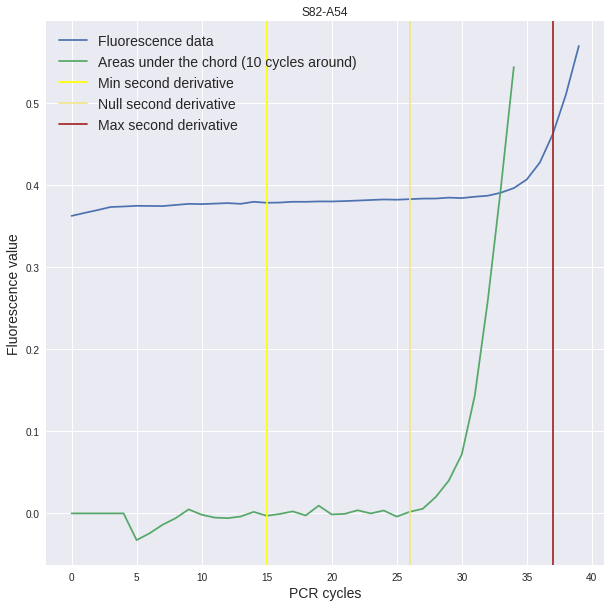

In [346]:
## Check area under the chord for one curve
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

#curve = "S02-A28" # Regular curve
#curve = "S90-A10" # Flat curve
#curve = "S06-A93" # No top plateau
curve = "S82-A54" # Starting late

# For each window of 10 cycles
areas = np.array([])
for cycle in range(0, 30):
    # Getting the linear regression coordinates
    slope, intercept, r_value, p_value, std_err = stats.linregress([cycle, cycle + 10], [fluo.loc[curve][cycle], fluo.loc[curve][cycle + 10]])
    # Computing the area under the chord (sum of the diff between the chord and curve for the 10 cycles)
    areas = np.append(areas, np.sum([(((cycle + p) * slope) + intercept) - fluo.loc[curve][cycle + p] for p in range(10)]))
    """
    # Displaying the linear regression curves
    points = []
    for p in range(40):
        points.append((p * slope) + intercept)
    ax.plot(points)
    """

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(fluo.loc[curve], label="Fluorescence data")
ax.plot(np.concatenate([np.zeros(5), areas]), label="Areas under the chord (10 cycles around)")
plt.xlabel("PCR cycles", fontsize=14)
plt.ylabel("Fluorescence value", fontsize=14)
plt.title(curve)
plt.axvline(x=min_second_derivative(list(fluo.loc[curve])), color="yellow", label="Min second derivative")
plt.axvline(x=null_second_derivative(list(fluo.loc[curve])), color="khaki", label="Null second derivative")
plt.axvline(x=max_second_derivative(list(fluo.loc[curve])), color="brown", label="Max second derivative")
plt.title(curve)
legend = plt.legend(loc="upper left", shadow=True, fontsize=14)
#axes = plt.gca()
#axes.set_ylim(-0.05, 0.5)

In [24]:
## Check areas under the chord amplitude distribution
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys
%matplotlib inline

print "Starting..."
# Getting the areas
areas_amplitude = []
i = 0
for curve in fluo.index.values:
    i += 1
    if i % 1000 == 0:
        print str(i) + " curve processed..."
    # For each window of 10 cycles
    areas = np.array([])
    for cycle in range(0, 30):
        # Getting the linear regression coordinates
        slope, intercept, r_value, p_value, std_err = stats.linregress([cycle, cycle + 10], [fluo.loc[curve][cycle], fluo.loc[curve][cycle + 10]])
        # Computing the area under the chord (sum of the diff between the curve and chord for the 10 cycles)
        areas = np.append(areas, np.sum([(((cycle + p) * slope) + intercept) - fluo.loc[curve][cycle + p] for p in range(10)]))
    areas_amplitude.append(max(areas) - min(areas))

# Finding the threshold
threshold = np.array([])
i = 0
for curve_n in range(0, 9016):
    i += 1
    if i % 1000 == 0:
        print str(i) + " curve processed..."
    # Getting the linear regression coordinates
    slope, intercept, r_value, p_value, std_err = stats.linregress([curve_n, curve_n + 200], [sorted(areas_amplitude)[curve_n], sorted(areas_amplitude)[curve_n + 200]])
    # Computing the area under the chord (sum of the diff between the curve and chord for the 10 cycles)
    threshold = np.append(threshold, np.sum([(((curve_n + p) * slope) + intercept) - sorted(areas_amplitude)[curve_n + p] for p in range(200)]))

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(sorted(areas_amplitude), label="Sorted areas amplitude")
plt.axvline(x=max_second_derivative(sorted(areas_amplitude)), color="brown", label="Max second derivative")
plt.xlabel("PCR cycles", fontsize=14)
plt.ylabel("Areas amplitude", fontsize=14)
legend = plt.legend(loc="upper left", shadow=True, fontsize=14)

Starting...
1000 curve processed...
2000 curve processed...
3000 curve processed...
4000 curve processed...
5000 curve processed...
6000 curve processed...
7000 curve processed...
8000 curve processed...
9000 curve processed...


KeyboardInterrupt: 

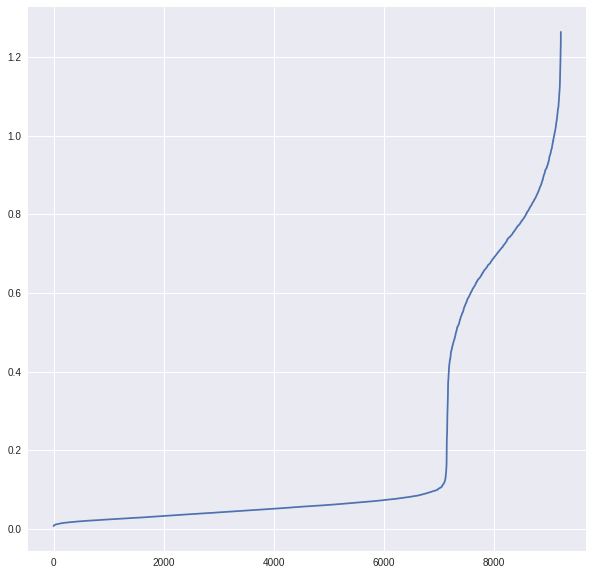

In [13]:
## Find the flat curves
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the max-min differences
max_min_diff = pd.read_csv("/data/biocomp/bahin/qPCR/Test/max_min_diff.tsv", sep="\t", usecols=[3])

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
plt.plot(max_min_diff)
#plt.plot(derivative(max_min_diff.values))
#n, bins, patches = plt.hist(max_min_diff.values, bins=4)
#print n

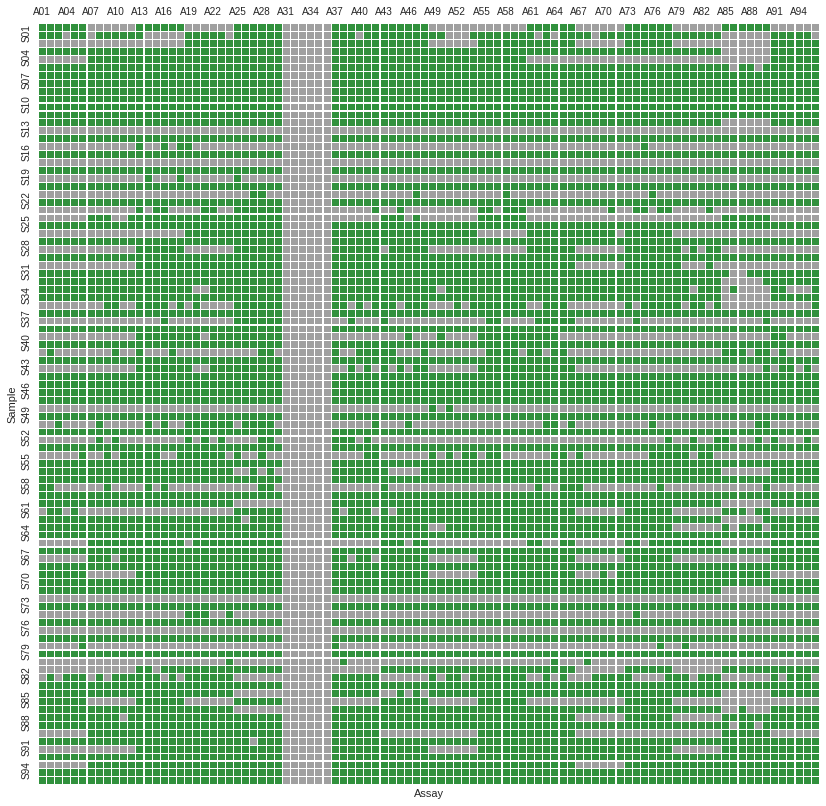

In [44]:
## TO COMPLETE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Loadind data
data = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/sigmoid_flat.heatmap.tsv", sep="\t")

# Splitting the sample ID into sample and assay
data["Sample"], data["Assay"] = zip(*data["Well_ID"].map(lambda x: x.split("-")))

# Filtering and pivoting the data
processed_data = data[["Sample", "Assay", "Sigmoid"]].pivot(index="Sample", columns="Assay", values = "Sigmoid")

# Defining colors
colors = ["#a0a0a0", "#31913d"]
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

# Plotting the heatmap
#fig = plt.figure(figsize=(18, 18))
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(111)
ax = sns.heatmap(processed_data, xticklabels=3, yticklabels=3, cmap=my_cmap, cbar=False, linewidth=0.1)
ax.xaxis.tick_top()

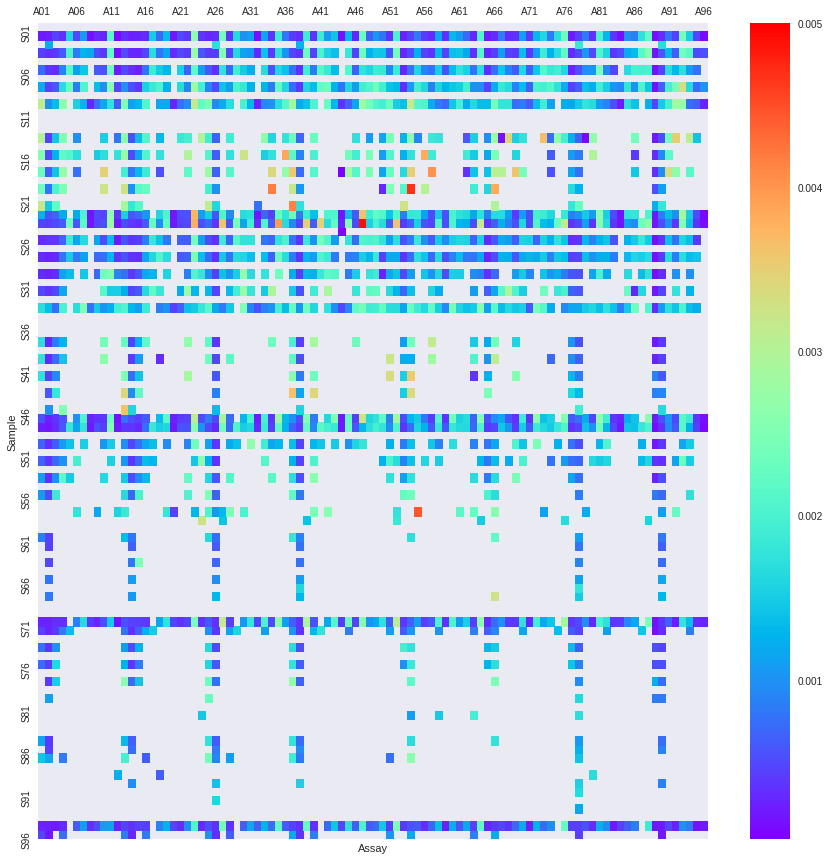

In [90]:
## RSS heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loadind data
#data = pd.read_csv("/data/biocomp/bahin/qPCR/Onefit_upgrade/results.MB_version.MeanRSS.tsv", sep="\t")
data = pd.read_csv("/data/biocomp/bahin/qPCR/results.4p_6p.0.tsv", sep="\t")
# Splitting the sample ID into sample and assay
data["Sample"], data["Assay"] = zip(*data["Sample ID"].map(lambda x: x.split("-")))
# Filtering and pivoting the data
processed_data = data[["Sample", "Assay", "6p RSS"]].pivot(index="Sample", columns="Assay", values = "6p RSS")
# Plotting the heatmap
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
ax = sns.heatmap(processed_data, xticklabels=5, yticklabels=5, vmax = 0.005, cmap=plt.cm.rainbow)
ax.xaxis.tick_top()

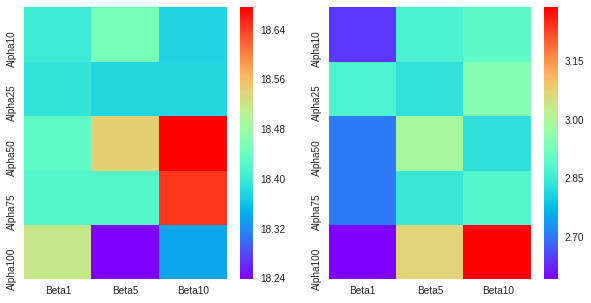

In [35]:
# Comparing different ranges of values for alpha and beta parameters
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loadind data
p4 = pd.read_csv("/data/biocomp/bahin/qPCR/Alpha_beta_bounds/4p.tsv", sep="\t", header=0, index_col=0)
p6 = pd.read_csv("/data/biocomp/bahin/qPCR/Alpha_beta_bounds/6p.tsv", sep="\t", header=0, index_col=0)

# Plotting the heatmap
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax = sns.heatmap(p4, cmap=plt.cm.rainbow)
ax2 = plt.subplot(122)
ax2 = sns.heatmap(p6, cmap=plt.cm.rainbow)

In [3]:
## Interactive 4-parameters sigmoid builder
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(mini=0.409, maxi=1.120, F0=0.001, E=1.393):
    plt.figure(figsize=(10, 10))
    x = np.arange(40)
    plt.plot(x, logistic4parameters(x, mini, maxi, F0, E))
    plt.ylim(0, 2)
    plt.show()

interactive_plot = interactive(f, mini=(0.0, 2.0, 0.001), maxi=(0.0, 2.0, 0.001), F0=(0.0, 2.0, 0.001), E=(1.0, 2.0, 0.001))
#output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot

In [36]:
## Interactive 6-parameters sigmoid builder
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(mini=0.409, maxi=1.120, F0=0.001, E=1.393, alpha=0.07, beta=-28):
    plt.figure(2, figsize=(10, 10))
    x = np.arange(40)
    plt.plot(x, logistic6parameters(x, mini, maxi, F0, E, alpha, beta))
    plt.ylim(0, 2)
    plt.show()

interactive_plot = interactive(f, mini=(0.0, 2.0, 0.001), maxi=(0.0, 2.0, 0.001), F0=(0.0, 2.0, 0.001), E=(1.0, 2.0, 0.001), alpha=(-1.0, 1.0, 0.001), beta=(-100, 10.0, 0.001))
#output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot

In [376]:
## Interactive plot from paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2892436/#S1
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def L3_model(x, b, d, e):
    return float(d) / (1 + np.exp(float(b) * (np.log10(x) - float(e))))

def f(b=-9.9, d=11.07, e=24.75):
    plt.figure(2, figsize=(10, 10))
    x = np.arange(10, 36)
    plt.plot(x, L3_model(x, b, d, e))
    plt.show()

interactive_plot = interactive(f, b=(-15., 20., 1), d=(5., 15., 1), e=(0., 30., 1))
interactive_plot

In [4]:
## Interactive plot example
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

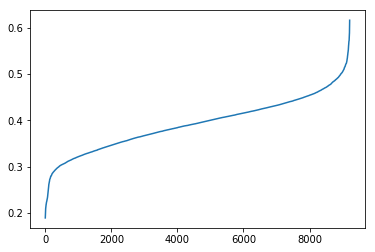

In [10]:
## Checking F0 range
import matplotlib
import pylab
%matplotlib inline

#data = pd.read_csv("/data/biocomp/bahin/qPCR/F0.txt", sep="\t", header=0, index_col=0)
data = pylab.loadtxt("/data/biocomp/bahin/qPCR/F0.sort.txt")
pylab.plot(data)

In [1]:
### Defining the rows order
rows = []

l = ["A" + format(i, "02d") for i in range(1, 49)]
print(range(54, 97, 6))
"""
for i in [54, 60, 66, 61, 72->A67
A78->A73
A84->A79
A90->A85
A96->A91 ]
"""
print(l)

range(54, 97, 6)
['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48']
